In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("rfm_data.csv")
df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LAST_TO_END   62988 non-null  int64
 1   FLIGHT_COUNT  62988 non-null  int64
 2   SEG_KM_SUM    62988 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [4]:
df.describe()

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
count,62988.000000,62988.000000,62988.000000
mean,176.120102,11.839414,17123.878691
std,183.822223,14.049471,20960.844623
min,1.000000,2.000000,368.000000
25%,29.000000,3.000000,4747.000000
50%,108.000000,7.000000,9994.000000
75%,268.000000,15.000000,21271.250000
max,731.000000,213.000000,580717.000000


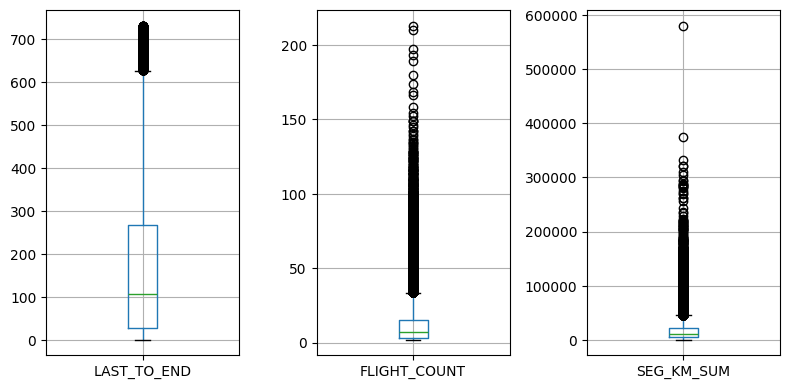

In [5]:
# Outlier Checking

list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df.boxplot(column_name, ax=ax.flatten()[i])
    

plt.tight_layout()
plt.show()

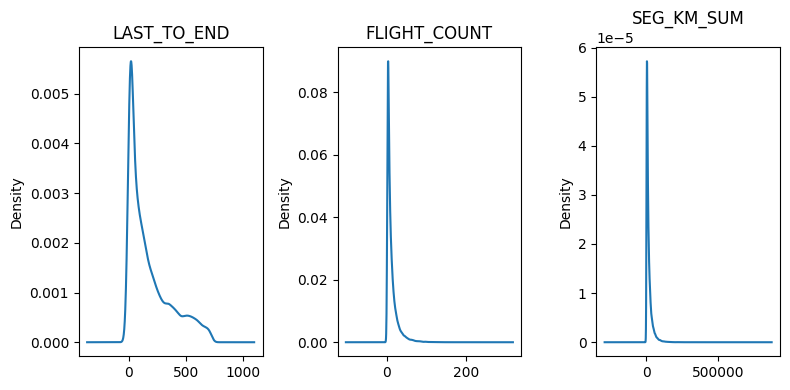

In [6]:
# Distribution of Data
 
list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

In [7]:
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

In [8]:
df

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# Data Pre-processing 

In [9]:
df.corr()

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
LAST_TO_END (R),1.000000,-0.404999,-0.369509
FLIGHT_COUNT (F),-0.404999,1.000000,0.850411
SEG_KM_SUM (M),-0.369509,0.850411,1.000000


In [10]:
from sklearn.preprocessing import QuantileTransformer

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = quantile_trans.fit_transform(df)

In [11]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.418119,3.226932,3.489913
2,-1.204935,3.193076,3.428931
3,-0.075345,1.086456,3.416106
4,-1.566990,3.327632,3.630408
...,...,...,...
62983,0.746351,-5.199338,-2.522188
62984,-0.121995,-0.513491,-0.182557
62985,-0.702315,-5.199338,-1.379267
62986,1.038381,-5.199338,-0.884593


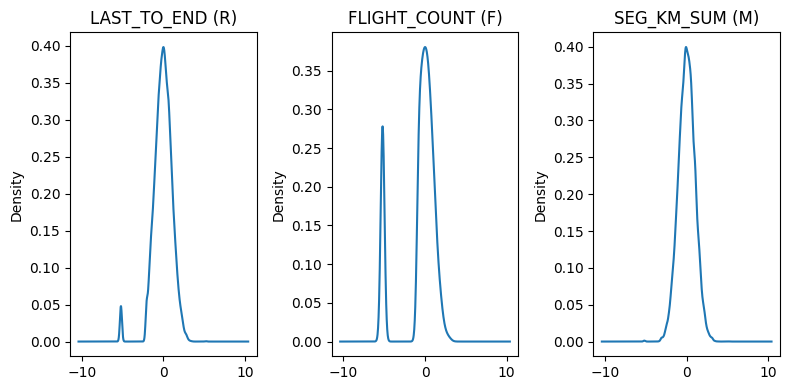

In [12]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df_scaled[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

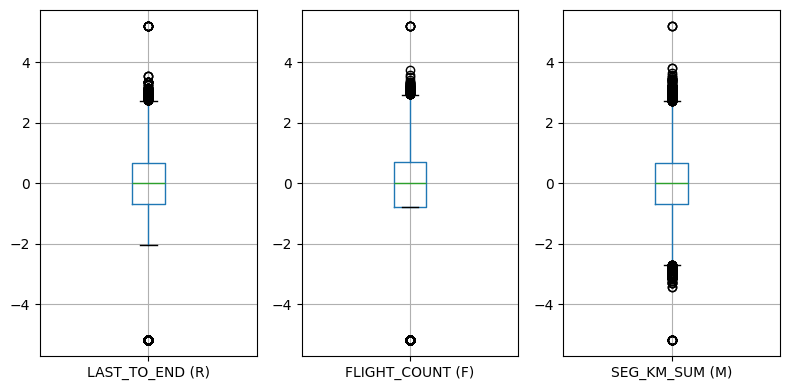

In [13]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 4))

for i, column_name in enumerate(list_columns):
    df_scaled.boxplot(column_name, ax=ax.flatten()[i])

plt.tight_layout()
plt.show()

In [14]:
# Outlier Persentation

for i, j in df_scaled.items():
    q1 = j.quantile(0.25)
    q3 = j.quantile(0.75)
    inter_q = q3 - q1

    j_col = j[(j <= q1 - 1.5 * inter_q) | (j >= q3 + 1.5 * inter_q)]
    percent = np.shape(j_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f" %(i, percent))

Column LAST_TO_END (R) outliers = 1.85
Column FLIGHT_COUNT (F) outliers = 16.68
Column SEG_KM_SUM (M) outliers = 0.73


# Robust Trimmed K Means


In [17]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

df_scaled_np = df_scaled.to_numpy()

RTKM_data = RTKM(df_scaled_np.T)
RTKM_data.perform_clustering(k=3, percent_outliers = 0.10, max_iter = 100, num_members = 2)

#pred clusters return cluster id for data index, pred outliers return outlier index
pred_clusters, pred_outliers = RTKM_data.return_clusters()

Iteration 100
PALM reached maximum number of iterations


In [22]:
print(pred_clusters.shape) #semua titik mendapatkan cluster id
print(pred_outliers.shape) #jumlah percentage yang terpotong menjadi outliers

print(pred_clusters) #return cluster id untuk setiap titik
print(pred_outliers) #return index data yang terdeteksi sebagai outliers

(62988,)
(6303,)
[3 3 3 ... 0 0 0]
[    0     1     2 ... 62966 62974 62975]


In [23]:
#Append dataset sehingga mendapatkan id
cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])

RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

RTKM_result

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
0,-5.199338,5.199338,5.199338,3
1,-1.374878,3.282383,3.182196,3
2,-1.171890,3.212629,3.172298,3
3,-0.092972,1.064091,3.169984,3
4,-1.529558,3.580367,3.199036,3
...,...,...,...,...
62983,0.723436,-5.199338,-2.416655,0
62984,-0.134645,-0.493553,-0.186788,1
62985,-0.686350,-5.199338,-1.387319,0
62986,1.018778,-5.199338,-0.877196,0


In [24]:
# Create a mask for the indices in the DataFrame that need to be modified
mask = np.isin(RTKM_result.index, pred_outliers)

# Use np.where to conditionally replace values in cluster_id
RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])

RTKM_result

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
0,-5.199338,5.199338,5.199338,3-out
1,-1.374878,3.282383,3.182196,3-out
2,-1.171890,3.212629,3.172298,3-out
3,-0.092972,1.064091,3.169984,3-out
4,-1.529558,3.580367,3.199036,3-out
...,...,...,...,...
62983,0.723436,-5.199338,-2.416655,0
62984,-0.134645,-0.493553,-0.186788,1
62985,-0.686350,-5.199338,-1.387319,0
62986,1.018778,-5.199338,-0.877196,0


In [25]:
# Use boolean indexing to filter out rows based on indices_to_remove
RTKM_result_filtered = RTKM_result[~RTKM_result.index.isin(pred_outliers)]

RTKM_result_filtered

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M),cluster_id
230,0.338834,0.412900,2.465248,1
245,-0.082896,0.412900,2.461500,1
335,0.140977,0.493553,2.362317,1
349,0.875354,0.493553,2.309049,1
357,-0.290058,1.269664,1.969110,1
...,...,...,...,...
62983,0.723436,-5.199338,-2.416655,0
62984,-0.134645,-0.493553,-0.186788,1
62985,-0.686350,-5.199338,-1.387319,0
62986,1.018778,-5.199338,-0.877196,0


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

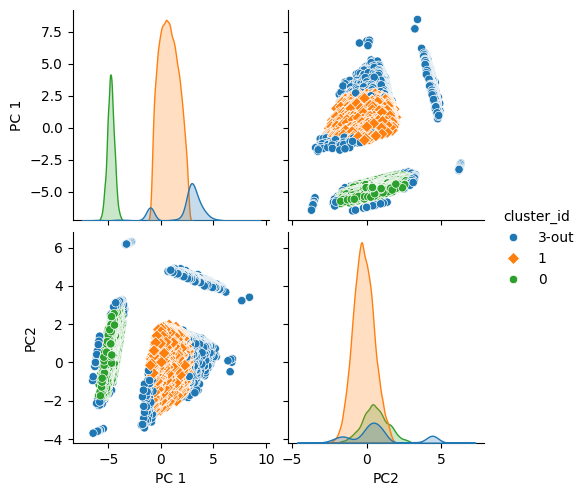

<Figure size 800x800 with 0 Axes>

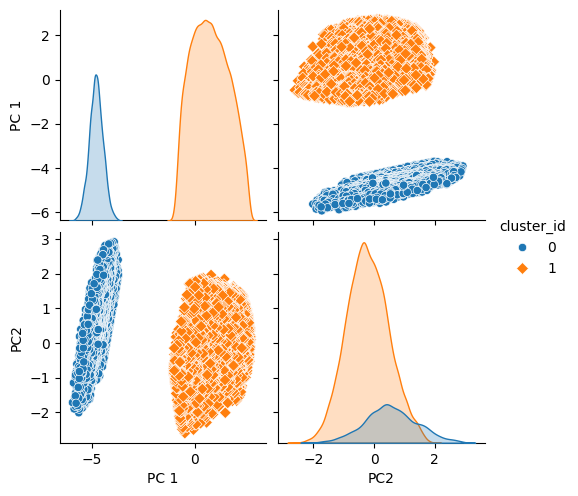

In [26]:
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = RTKM_result.loc[:, RTKM_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])


#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = RTKM_result_filtered.loc[:, RTKM_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

# RTKM FIXED FUNCTION

In [23]:
#generate data RTKM untuk comply dengan func silhouette score
def generate_data_RTKM(dataframe, k, percent_outliers, num_members):
    dataframe_np_transposed = dataframe.to_numpy().T

    RTKM_data = RTKM(dataframe_np_transposed)
    RTKM_data.perform_clustering(k=k, percent_outliers = percent_outliers, max_iter = 100, num_members = num_members)
    print(k, percent_outliers, num_members)
    
    #pred clusters return cluster id for data index, pred outliers return outlier index
    pred_clusters, pred_outliers = RTKM_data.return_clusters()

    #Append dataset sehingga mendapatkan id
    cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])
    RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

    # Create a mask for the indices in the DataFrame that need to be modified
    mask = np.isin(RTKM_result.index, pred_outliers)

    # Use np.where to conditionally replace values in cluster_id
    RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])
    all_data = RTKM_result

    # Use boolean indexing to filter out rows based on indices_to_remove
    filtered_data = RTKM_result[~RTKM_result.index.isin(pred_outliers)]
    
    return filtered_data, all_data

### TEST

In [24]:
inliers, all = generate_data_RTKM(df_scaled, 3, 0.10, 2)
print("All data:\n", all)
print("CID ALL:", all['cluster_id'].unique())
print("Filtered data:\n", inliers)
print("CID FILTERED:", inliers['cluster_id'].unique())

Iteration 100
PALM reached maximum number of iterations
3 0.1 2
All data:
        LAST_TO_END (R)  FLIGHT_COUNT (F)  SEG_KM_SUM (M) cluster_id
0            -5.199338          5.199338        5.199338      3-out
1            -1.418119          3.226932        3.489913      3-out
2            -1.204935          3.193076        3.428931      3-out
3            -0.075345          1.086456        3.416106      3-out
4            -1.566990          3.327632        3.630408      3-out
...                ...               ...             ...        ...
62983         0.746351         -5.199338       -2.522188          0
62984        -0.121995         -0.513491       -0.182557          0
62985        -0.702315         -5.199338       -1.379267          0
62986         1.038381         -5.199338       -0.884593          0
62987         1.050924         -5.199338       -0.784953          0

[62988 rows x 4 columns]
CID ALL: ['3-out' 0]
Filtered data:
        LAST_TO_END (R)  FLIGHT_COUNT (F)  SEG_

<Figure size 800x800 with 0 Axes>

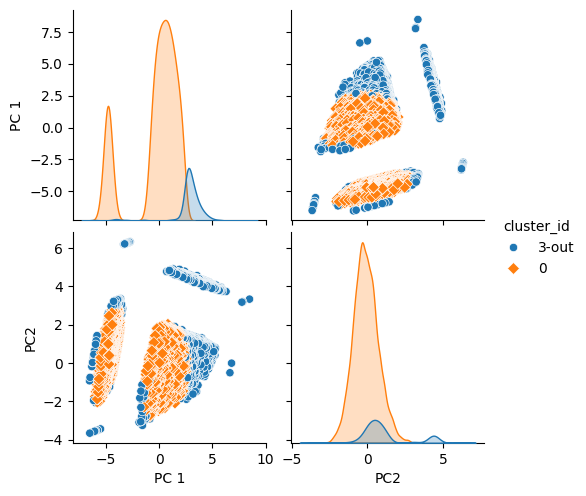

In [25]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = all.loc[:, all.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

## OPTIMAL PERCENTAGE

In [19]:
from sklearn.metrics import silhouette_score

# Function find optimal RTKM cluster
def find_optimal_RTKM(df):
    best_score = -1
    best_percent = 0
    best_cluster = None
    best_all = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)

        # Jalankan RTKM dengan parameter tertentu
        retry_count = 0
        max_retries = 3  # Tentukan jumlah maksimum percobaan

        while retry_count < max_retries:
            inliers, all_data = generate_data_RTKM(df, 2, percent / 100, 2)
            inliers_no_id = inliers.drop(['cluster_id'], axis=1)

            print(inliers.shape)

            # Skip invalid data
            if inliers["cluster_id"].nunique() == 1:
                print("Invalid data, retrying...")
                retry_count += 1
                continue

            # Hitung skor siluet
            score = silhouette_score(inliers_no_id, inliers['cluster_id'])
            print("Score:", score)

            # Perbarui parameter terbaik jika skor lebih tinggi
            if score > best_score:
                best_score = score
                best_percent = percent
                best_cluster = inliers
                best_all = all_data

            break  # Keluar dari loop retry jika data valid

    print("Best Silhouette Score:", best_score)
    print("Best Percent:", best_percent)

    return best_cluster, best_all

optimal_inlier, optimal_cluster = find_optimal_RTKM(df_scaled)

PERCENT: 5
Iteration 100
PALM reached maximum number of iterations
2 0.05 2
(59834, 4)
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 2
(59838, 4)
Score: 0.7157100851253596
PERCENT: 10
Iteration 100
PALM reached maximum number of iterations
2 0.1 2
(56685, 4)
Score: 0.7251040617611912
PERCENT: 15
Iteration 100
PALM reached maximum number of iterations
2 0.15 2
(53518, 4)
Score: 0.7322866911805452
PERCENT: 20
Iteration 100
PALM reached maximum number of iterations
2 0.2 2
(50368, 4)
Score: 0.08895179341224578
PERCENT: 25
Iteration 100
PALM reached maximum number of iterations
2 0.25 2
(47192, 4)
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 2
(47206, 4)
Score: 0.08130769751565574
PERCENT: 30
Iteration 100
PALM reached maximum number of iterations
2 0.3 2
(44076, 4)
Score: 0.7504329287463191
Best Silhouette Score: 0.7504329287463191
Best Percent: 30


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)


<Figure size 800x800 with 0 Axes>

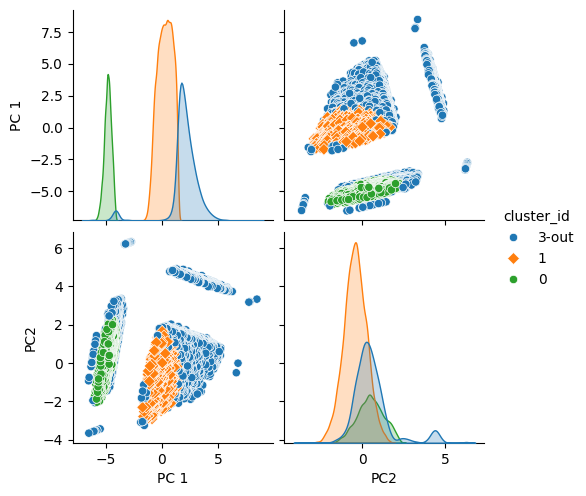

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = optimal_cluster.loc[:, optimal_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

# ALL PARAMS

In [107]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import time  # Import library untuk menambahkan delay antar iterasi

# Parameter yang akan diuji
param_grid = {
    'k': range(1, 11),                   # K dari 1 hingga 10
    'percent_outliers': range(5, 31, 5), # Persentase outliers dari 5% hingga 30%
    'num_members': range(1, 11)          # Num members dari 1 hingga 10
}

# Function find optimal RTKM cluster
def find_optimal_RTKM_test(df):
    best_score = -1
    best_params = None
    best_cluster = None
    best_all = None

    for params in tqdm(list(ParameterGrid(param_grid))):
        k = params['k']
        percent_outliers = params['percent_outliers'] / 100.0
        num_members = params['num_members']
        print(k, percent_outliers, num_members)

        # Retry RTKM ketika inliers["cluster_id"].nunique() == 1
        retry_count = 0
        max_retries = 3  # Tentukan jumlah maksimum percobaan

        while retry_count < max_retries:
            # Jalankan RTKM dengan parameter tertentu
            inliers, all_data = generate_data_RTKM(df, k, percent_outliers, num_members)
            inliers_no_id = inliers.drop(['cluster_id'], axis=1)

            # Skip invalid data
            if inliers["cluster_id"].nunique() == 1:
                print("Invalid data, retrying...")
                retry_count += 1
                time.sleep(1)  # Tambahkan delay sebelum menjalankan retry
                continue

            # Hitung skor siluet
            score = silhouette_score(inliers_no_id, inliers['cluster_id'])
            print("Score:", score)

            # Perbarui parameter terbaik jika skor lebih tinggi
            if score > best_score:
                best_score = score
                best_params = params
                best_cluster = inliers
                best_all = all_data

            break  # Keluar dari loop retry jika data valid

    print("Best Silhouette Score:", best_score)
    print("Best Parameters:", best_params)

    return best_cluster, best_all

optimal_inlier, optimal_cluster = find_optimal_RTKM_test(df_scaled)

  0%|          | 0/600 [00:00<?, ?it/s]

1 0.05 1
Iteration 100
PALM reached maximum number of iterations
1 0.05 1


  0%|          | 1/600 [01:03<10:32:35, 63.37s/it]

Score: 0.7200361567614704
1 0.1 1
Iteration 100
PALM reached maximum number of iterations
1 0.1 1


  0%|          | 2/600 [01:52<9:08:33, 55.04s/it] 

Score: 0.7353358365948011
1 0.15 1
Iteration 100
PALM reached maximum number of iterations
1 0.15 1


  0%|          | 3/600 [02:36<8:17:46, 50.03s/it]

Score: 0.7483909723271657
1 0.2 1
Iteration 100
PALM reached maximum number of iterations
1 0.2 1


  1%|          | 4/600 [03:15<7:35:03, 45.81s/it]

Score: 0.4163186167838925
1 0.25 1
Iteration 100
PALM reached maximum number of iterations
1 0.25 1


  1%|          | 5/600 [03:50<6:55:27, 41.90s/it]

Score: 0.4220054601678048
1 0.3 1
Iteration 100
PALM reached maximum number of iterations
1 0.3 1


  1%|          | 6/600 [04:21<6:18:02, 38.19s/it]

Score: 0.4263576897297326
1 0.05 2
Iteration 100
PALM reached maximum number of iterations
1 0.05 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 2
Invalid data, retrying...


  1%|          | 7/600 [05:44<8:42:24, 52.86s/it]

1 0.1 2
Iteration 100
PALM reached maximum number of iterations
1 0.1 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 2
Invalid data, retrying...


  1%|▏         | 8/600 [07:07<10:15:53, 62.42s/it]

1 0.15 2
Iteration 100
PALM reached maximum number of iterations
1 0.15 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 2
Invalid data, retrying...


  2%|▏         | 9/600 [08:31<11:19:43, 69.01s/it]

1 0.2 2
Iteration 100
PALM reached maximum number of iterations
1 0.2 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 2
Invalid data, retrying...


  2%|▏         | 10/600 [09:59<12:15:43, 74.82s/it]

1 0.25 2
Iteration 100
PALM reached maximum number of iterations
1 0.25 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 2
Invalid data, retrying...


  2%|▏         | 11/600 [11:23<12:41:40, 77.59s/it]

1 0.3 2
Iteration 100
PALM reached maximum number of iterations
1 0.3 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 2
Invalid data, retrying...


  2%|▏         | 12/600 [12:46<12:56:51, 79.27s/it]

1 0.05 3
Iteration 100
PALM reached maximum number of iterations
1 0.05 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 3


  2%|▏         | 13/600 [15:01<15:41:36, 96.25s/it]

Score: -0.30985763966376684
1 0.1 3
Iteration 100
PALM reached maximum number of iterations
1 0.1 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 3
Invalid data, retrying...


  2%|▏         | 14/600 [16:25<15:04:31, 92.61s/it]

1 0.15 3
Iteration 100
PALM reached maximum number of iterations
1 0.15 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 3


  2%|▎         | 15/600 [18:00<15:09:04, 93.24s/it]

Score: 0.006550797981001006
1 0.2 3
Iteration 100
PALM reached maximum number of iterations
1 0.2 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 3


  3%|▎         | 16/600 [19:31<15:00:47, 92.55s/it]

Score: -0.09858704715032973
1 0.25 3
Iteration 100
PALM reached maximum number of iterations
1 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 3
Invalid data, retrying...


  3%|▎         | 17/600 [20:54<14:32:46, 89.82s/it]

1 0.3 3
Iteration 100
PALM reached maximum number of iterations
1 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 3
Invalid data, retrying...


  3%|▎         | 18/600 [22:18<14:12:50, 87.92s/it]

1 0.05 4
Iteration 100
PALM reached maximum number of iterations
1 0.05 4


  3%|▎         | 19/600 [23:35<13:40:22, 84.72s/it]

Score: -0.29980536000657354
1 0.1 4
Iteration 100
PALM reached maximum number of iterations
1 0.1 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 4
Invalid data, retrying...


  3%|▎         | 20/600 [25:03<13:47:51, 85.64s/it]

1 0.15 4
Iteration 100
PALM reached maximum number of iterations
1 0.15 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 4
Invalid data, retrying...


  4%|▎         | 21/600 [26:27<13:42:14, 85.21s/it]

1 0.2 4
Iteration 100
PALM reached maximum number of iterations
1 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 4


  4%|▎         | 22/600 [27:58<13:57:05, 86.90s/it]

Score: 0.031846806504958886
1 0.25 4
Iteration 100
PALM reached maximum number of iterations
1 0.25 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 4


  4%|▍         | 23/600 [29:52<15:14:46, 95.12s/it]

Score: -0.24039539621715925
1 0.3 4
Iteration 100
PALM reached maximum number of iterations
1 0.3 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 4
Invalid data, retrying...


  4%|▍         | 24/600 [31:17<14:44:31, 92.14s/it]

1 0.05 5
Iteration 100
PALM reached maximum number of iterations
1 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 5
Invalid data, retrying...


  4%|▍         | 25/600 [32:40<14:14:37, 89.18s/it]

1 0.1 5
Iteration 100
PALM reached maximum number of iterations
1 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 5
Invalid data, retrying...


  4%|▍         | 26/600 [34:02<13:53:49, 87.16s/it]

1 0.15 5
Iteration 100
PALM reached maximum number of iterations
1 0.15 5


  4%|▍         | 27/600 [35:08<12:52:05, 80.85s/it]

Score: -0.3356688093467333
1 0.2 5
Iteration 100
PALM reached maximum number of iterations
1 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 5


  5%|▍         | 28/600 [37:05<14:34:15, 91.70s/it]

Score: -0.1688757298641832
1 0.25 5
Iteration 100
PALM reached maximum number of iterations
1 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 5
Invalid data, retrying...


  5%|▍         | 29/600 [38:28<14:07:27, 89.05s/it]

1 0.3 5
Iteration 100
PALM reached maximum number of iterations
1 0.3 5


  5%|▌         | 30/600 [39:21<12:23:46, 78.29s/it]

Score: -0.09253993405911677
1 0.05 6
Iteration 100
PALM reached maximum number of iterations
1 0.05 6


  5%|▌         | 31/600 [40:37<12:16:13, 77.63s/it]

Score: 0.04064111336340945
1 0.1 6
Iteration 100
PALM reached maximum number of iterations
1 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 6
Invalid data, retrying...


  5%|▌         | 32/600 [42:00<12:28:37, 79.08s/it]

1 0.15 6
Iteration 100
PALM reached maximum number of iterations
1 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 6
Invalid data, retrying...


  6%|▌         | 33/600 [43:22<12:35:22, 79.93s/it]

1 0.2 6
Iteration 100
PALM reached maximum number of iterations
1 0.2 6


  6%|▌         | 34/600 [44:25<11:46:18, 74.87s/it]

Score: 0.25601429634676826
1 0.25 6
Iteration 100
PALM reached maximum number of iterations
1 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 6
Invalid data, retrying...


  6%|▌         | 35/600 [45:48<12:08:22, 77.35s/it]

1 0.3 6
Iteration 100
PALM reached maximum number of iterations
1 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 6
Invalid data, retrying...


  6%|▌         | 36/600 [47:13<12:28:10, 79.59s/it]

1 0.05 7
Iteration 100
PALM reached maximum number of iterations
1 0.05 7


  6%|▌         | 37/600 [48:28<12:14:20, 78.26s/it]

Score: -0.2579602749525927
1 0.1 7
Iteration 100
PALM reached maximum number of iterations
1 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 7
Invalid data, retrying...


  6%|▋         | 38/600 [49:50<12:24:53, 79.52s/it]

1 0.15 7
Iteration 100
PALM reached maximum number of iterations
1 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 7
Invalid data, retrying...


  6%|▋         | 39/600 [51:14<12:33:42, 80.61s/it]

1 0.2 7
Iteration 100
PALM reached maximum number of iterations
1 0.2 7


  7%|▋         | 40/600 [52:16<11:40:26, 75.05s/it]

Score: -0.2793882043759565
1 0.25 7
Iteration 100
PALM reached maximum number of iterations
1 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 7


  7%|▋         | 41/600 [54:08<13:24:36, 86.36s/it]

Score: -0.13569095020220695
1 0.3 7
Iteration 100
PALM reached maximum number of iterations
1 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 7


  7%|▋         | 42/600 [55:29<13:06:49, 84.60s/it]

Score: -0.10036131330989227
1 0.05 8
Iteration 100
PALM reached maximum number of iterations
1 0.05 8


  7%|▋         | 43/600 [56:44<12:39:53, 81.86s/it]

Score: -0.06481185046199173
1 0.1 8
Iteration 100
PALM reached maximum number of iterations
1 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 8


  7%|▋         | 44/600 [58:50<14:38:59, 94.85s/it]

Score: -0.0875527269847999
1 0.15 8
Iteration 100
PALM reached maximum number of iterations
1 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 8
Invalid data, retrying...


  8%|▊         | 45/600 [1:00:12<14:03:16, 91.16s/it]

1 0.2 8
Iteration 100
PALM reached maximum number of iterations
1 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 8


  8%|▊         | 46/600 [1:02:09<15:12:37, 98.84s/it]

Score: -0.27974020072225947
1 0.25 8
Iteration 100
PALM reached maximum number of iterations
1 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 8


  8%|▊         | 47/600 [1:04:01<15:48:11, 102.88s/it]

Score: -0.07363206598377349
1 0.3 8
Iteration 100
PALM reached maximum number of iterations
1 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 8
Invalid data, retrying...


  8%|▊         | 48/600 [1:05:25<14:54:43, 97.25s/it] 

1 0.05 9
Iteration 100
PALM reached maximum number of iterations
1 0.05 9


  8%|▊         | 49/600 [1:06:42<13:55:57, 91.03s/it]

Score: -0.17783677614258775
1 0.1 9
Iteration 100
PALM reached maximum number of iterations
1 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 9


  8%|▊         | 50/600 [1:08:48<15:30:26, 101.50s/it]

Score: 0.018242529546760117
1 0.15 9
Iteration 100
PALM reached maximum number of iterations
1 0.15 9


  8%|▊         | 51/600 [1:09:54<13:53:09, 91.06s/it] 

Score: -0.11217682274390982
1 0.2 9
Iteration 100
PALM reached maximum number of iterations
1 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 9
Invalid data, retrying...


  9%|▊         | 52/600 [1:11:18<13:30:30, 88.74s/it]

1 0.25 9
Iteration 100
PALM reached maximum number of iterations
1 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 9
Invalid data, retrying...


  9%|▉         | 53/600 [1:12:42<13:15:43, 87.28s/it]

1 0.3 9
Iteration 100
PALM reached maximum number of iterations
1 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 9


  9%|▉         | 54/600 [1:14:02<12:56:40, 85.35s/it]

Score: 0.07198145986125382
1 0.05 10
Iteration 100
PALM reached maximum number of iterations
1 0.05 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.05 10


  9%|▉         | 55/600 [1:16:13<14:57:37, 98.82s/it]

Score: -0.3232031440499271
1 0.1 10
Iteration 100
PALM reached maximum number of iterations
1 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.1 10
Invalid data, retrying...


  9%|▉         | 56/600 [1:17:36<14:13:02, 94.09s/it]

1 0.15 10
Iteration 100
PALM reached maximum number of iterations
1 0.15 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.15 10
Invalid data, retrying...


 10%|▉         | 57/600 [1:19:00<13:44:38, 91.12s/it]

1 0.2 10
Iteration 100
PALM reached maximum number of iterations
1 0.2 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.2 10
Invalid data, retrying...


 10%|▉         | 58/600 [1:20:23<13:21:00, 88.67s/it]

1 0.25 10
Iteration 100
PALM reached maximum number of iterations
1 0.25 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.25 10
Invalid data, retrying...


 10%|▉         | 59/600 [1:21:46<13:03:34, 86.90s/it]

1 0.3 10
Iteration 100
PALM reached maximum number of iterations
1 0.3 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
1 0.3 10


 10%|█         | 60/600 [1:23:06<12:45:05, 85.01s/it]

Score: -0.11489009758196644
2 0.05 1
Iteration 100
PALM reached maximum number of iterations
2 0.05 1


 10%|█         | 61/600 [1:23:59<11:15:29, 75.19s/it]

Score: 0.46946351173277917
2 0.1 1
Iteration 100
PALM reached maximum number of iterations
2 0.1 1


 10%|█         | 62/600 [1:24:46<9:58:46, 66.78s/it] 

Score: 0.4780088572709762
2 0.15 1
Iteration 100
PALM reached maximum number of iterations
2 0.15 1


 10%|█         | 63/600 [1:25:28<8:52:41, 59.52s/it]

Score: 0.4831478728066204
2 0.2 1
Iteration 100
PALM reached maximum number of iterations
2 0.2 1


 11%|█         | 64/600 [1:26:07<7:57:00, 53.40s/it]

Score: 0.6782822622239256
2 0.25 1
Iteration 100
PALM reached maximum number of iterations
2 0.25 1


 11%|█         | 65/600 [1:26:42<7:05:08, 47.68s/it]

Score: 0.3388340038112716
2 0.3 1
Iteration 100
PALM reached maximum number of iterations
2 0.3 1


 11%|█         | 66/600 [1:27:12<6:17:25, 42.41s/it]

Score: 0.33347203695635674
2 0.05 2
Iteration 100
PALM reached maximum number of iterations
2 0.05 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 2


 11%|█         | 67/600 [1:28:59<9:09:55, 61.91s/it]

Score: 0.7182177352189429
2 0.1 2
Iteration 100
PALM reached maximum number of iterations
2 0.1 2


 11%|█▏        | 68/600 [1:30:12<9:36:32, 65.02s/it]

Score: 0.7299250993659672
2 0.15 2
Iteration 100
PALM reached maximum number of iterations
2 0.15 2


 12%|█▏        | 69/600 [1:31:19<9:41:24, 65.70s/it]

Score: 0.38874083114809505
2 0.2 2
Iteration 100
PALM reached maximum number of iterations
2 0.2 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 2


 12%|█▏        | 70/600 [1:32:52<10:54:01, 74.04s/it]

Score: 0.06707810055771467
2 0.25 2
Iteration 100
PALM reached maximum number of iterations
2 0.25 2
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 2


 12%|█▏        | 71/600 [1:34:21<11:32:41, 78.57s/it]

Score: 0.7490250099366219
2 0.3 2
Iteration 100
PALM reached maximum number of iterations
2 0.3 2


 12%|█▏        | 72/600 [1:35:17<10:31:36, 71.77s/it]

Score: 0.44857384270589157
2 0.05 3
Iteration 100
PALM reached maximum number of iterations
2 0.05 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 3
Invalid data, retrying...


 12%|█▏        | 73/600 [1:36:47<11:18:24, 77.24s/it]

2 0.1 3
Iteration 100
PALM reached maximum number of iterations
2 0.1 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 3
Invalid data, retrying...


 12%|█▏        | 74/600 [1:38:16<11:47:50, 80.74s/it]

2 0.15 3
Iteration 100
PALM reached maximum number of iterations
2 0.15 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 3
Invalid data, retrying...


 12%|█▎        | 75/600 [1:39:46<12:10:54, 83.53s/it]

2 0.2 3
Iteration 100
PALM reached maximum number of iterations
2 0.2 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 3
Invalid data, retrying...


 13%|█▎        | 76/600 [1:41:16<12:25:34, 85.37s/it]

2 0.25 3
Iteration 100
PALM reached maximum number of iterations
2 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 3
Invalid data, retrying...


 13%|█▎        | 77/600 [1:42:46<12:36:24, 86.78s/it]

2 0.3 3
Iteration 100
PALM reached maximum number of iterations
2 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 3
Invalid data, retrying...


 13%|█▎        | 78/600 [1:44:16<12:43:10, 87.72s/it]

2 0.05 4
Iteration 100
PALM reached maximum number of iterations
2 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 4
Invalid data, retrying...


 13%|█▎        | 79/600 [1:45:45<12:45:26, 88.15s/it]

2 0.1 4
Iteration 100
PALM reached maximum number of iterations
2 0.1 4


 13%|█▎        | 80/600 [1:46:58<12:04:58, 83.65s/it]

Score: -0.3591061486757474
2 0.15 4
Iteration 100
PALM reached maximum number of iterations
2 0.15 4


 14%|█▎        | 81/600 [1:48:06<11:22:58, 78.96s/it]

Score: 0.6069199467447958
2 0.2 4
Iteration 100
PALM reached maximum number of iterations
2 0.2 4


 14%|█▎        | 82/600 [1:49:10<10:42:12, 74.39s/it]

Score: 0.30454985758696645
2 0.25 4
Iteration 100
PALM reached maximum number of iterations
2 0.25 4


 14%|█▍        | 83/600 [1:50:11<10:07:21, 70.49s/it]

Score: -0.032013490913954605
2 0.3 4
Iteration 100
PALM reached maximum number of iterations
2 0.3 4


 14%|█▍        | 84/600 [1:51:10<9:34:40, 66.82s/it] 

Score: -0.08818103024296836
2 0.05 5
Iteration 100
PALM reached maximum number of iterations
2 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 5
Invalid data, retrying...


 14%|█▍        | 85/600 [1:52:41<10:35:23, 74.03s/it]

2 0.1 5
Iteration 100
PALM reached maximum number of iterations
2 0.1 5


 14%|█▍        | 86/600 [1:53:53<10:31:14, 73.69s/it]

Score: -0.3486507919171176
2 0.15 5
Iteration 100
PALM reached maximum number of iterations
2 0.15 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 5


 14%|█▍        | 87/600 [1:55:31<11:31:40, 80.90s/it]

Score: -0.356692461340552
2 0.2 5
Iteration 100
PALM reached maximum number of iterations
2 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 5


 15%|█▍        | 88/600 [1:57:05<12:03:29, 84.78s/it]

Score: -0.2562266332531101
2 0.25 5
Iteration 100
PALM reached maximum number of iterations
2 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 5
Invalid data, retrying...


 15%|█▍        | 89/600 [1:58:36<12:17:17, 86.57s/it]

2 0.3 5
Iteration 100
PALM reached maximum number of iterations
2 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 5


 15%|█▌        | 90/600 [2:00:32<13:30:51, 95.39s/it]

Score: -0.18623472773713431
2 0.05 6
Iteration 100
PALM reached maximum number of iterations
2 0.05 6


 15%|█▌        | 91/600 [2:01:50<12:45:33, 90.24s/it]

Score: -0.2770394328372256
2 0.1 6
Iteration 100
PALM reached maximum number of iterations
2 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 6


 15%|█▌        | 92/600 [2:03:33<13:15:34, 93.96s/it]

Score: 0.32242335749783874
2 0.15 6
Iteration 100
PALM reached maximum number of iterations
2 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 6


 16%|█▌        | 93/600 [2:05:10<13:23:54, 95.14s/it]

Score: -0.0894930312415831
2 0.2 6
Iteration 100
PALM reached maximum number of iterations
2 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 6


 16%|█▌        | 94/600 [2:06:45<13:19:43, 94.83s/it]

Score: 0.1463502762637133
2 0.25 6
Iteration 100
PALM reached maximum number of iterations
2 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 6
Invalid data, retrying...


 16%|█▌        | 95/600 [2:08:15<13:06:22, 93.43s/it]

2 0.3 6
Iteration 100
PALM reached maximum number of iterations
2 0.3 6


 16%|█▌        | 96/600 [2:09:11<11:30:34, 82.21s/it]

Score: -0.2502298395665981
2 0.05 7
Iteration 100
PALM reached maximum number of iterations
2 0.05 7


 16%|█▌        | 97/600 [2:10:30<11:20:39, 81.19s/it]

Score: -0.07009066014693383
2 0.1 7
Iteration 100
PALM reached maximum number of iterations
2 0.1 7


 16%|█▋        | 98/600 [2:11:43<10:59:32, 78.83s/it]

Score: -0.254607041138936
2 0.15 7
Iteration 100
PALM reached maximum number of iterations
2 0.15 7


 16%|█▋        | 99/600 [2:12:52<10:32:47, 75.78s/it]

Score: -0.11643197239100708
2 0.2 7
Iteration 100
PALM reached maximum number of iterations
2 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 7


 17%|█▋        | 100/600 [2:14:25<11:16:06, 81.13s/it]

Score: -0.257619646767541
2 0.25 7
Iteration 100
PALM reached maximum number of iterations
2 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 7


 17%|█▋        | 101/600 [2:16:25<12:50:58, 92.70s/it]

Score: 0.2708685116315704
2 0.3 7
Iteration 100
PALM reached maximum number of iterations
2 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 7


 17%|█▋        | 102/600 [2:17:51<12:31:53, 90.59s/it]

Score: 0.03125766507921995
2 0.05 8
Iteration 100
PALM reached maximum number of iterations
2 0.05 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 8


 17%|█▋        | 103/600 [2:20:08<14:28:02, 104.79s/it]

Score: -0.11787115158600459
2 0.1 8
Iteration 100
PALM reached maximum number of iterations
2 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 8
Invalid data, retrying...


 17%|█▋        | 104/600 [2:21:39<13:51:39, 100.60s/it]

2 0.15 8
Iteration 100
PALM reached maximum number of iterations
2 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.15 8


 18%|█▊        | 105/600 [2:23:49<15:02:03, 109.34s/it]

Score: -0.2627228485529702
2 0.2 8
Iteration 100
PALM reached maximum number of iterations
2 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 8


 18%|█▊        | 106/600 [2:25:53<15:37:35, 113.88s/it]

Score: -0.21799054939597917
2 0.25 8
Iteration 100
PALM reached maximum number of iterations
2 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 8


 18%|█▊        | 107/600 [2:27:53<15:50:16, 115.65s/it]

Score: -0.18023041909658286
2 0.3 8
Iteration 100
PALM reached maximum number of iterations
2 0.3 8


 18%|█▊        | 108/600 [2:28:49<13:20:30, 97.62s/it] 

Score: 0.014941806581057123
2 0.05 9
Iteration 100
PALM reached maximum number of iterations
2 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 9
Invalid data, retrying...


 18%|█▊        | 109/600 [2:30:19<13:00:19, 95.35s/it]

2 0.1 9
Iteration 100
PALM reached maximum number of iterations
2 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 9
Invalid data, retrying...


 18%|█▊        | 110/600 [2:31:49<12:46:12, 93.82s/it]

2 0.15 9
Iteration 100
PALM reached maximum number of iterations
2 0.15 9


 18%|█▊        | 111/600 [2:32:58<11:43:09, 86.28s/it]

Score: -0.16945760027774512
2 0.2 9
Iteration 100
PALM reached maximum number of iterations
2 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.2 9
Invalid data, retrying...


 19%|█▊        | 112/600 [2:34:41<12:23:50, 91.46s/it]

2 0.25 9
Iteration 100
PALM reached maximum number of iterations
2 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 9


 19%|█▉        | 113/600 [2:36:12<12:19:37, 91.12s/it]

Score: -0.017163299639878775
2 0.3 9
Iteration 100
PALM reached maximum number of iterations
2 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.3 9
Invalid data, retrying...


 19%|█▉        | 114/600 [2:37:42<12:16:22, 90.91s/it]

2 0.05 10
Iteration 100
PALM reached maximum number of iterations
2 0.05 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.05 10


 19%|█▉        | 115/600 [2:39:30<12:56:18, 96.04s/it]

Score: 0.40522178563446043
2 0.1 10
Iteration 100
PALM reached maximum number of iterations
2 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.1 10
Invalid data, retrying...


 19%|█▉        | 116/600 [2:41:01<12:41:08, 94.36s/it]

2 0.15 10
Iteration 100
PALM reached maximum number of iterations
2 0.15 10


 20%|█▉        | 117/600 [2:42:09<11:36:13, 86.49s/it]

Score: -0.21130629916593816
2 0.2 10
Iteration 100
PALM reached maximum number of iterations
2 0.2 10


 20%|█▉        | 118/600 [2:43:13<10:40:29, 79.73s/it]

Score: -0.1403939496309548
2 0.25 10
Iteration 100
PALM reached maximum number of iterations
2 0.25 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
2 0.25 10


 20%|█▉        | 119/600 [2:44:43<11:04:22, 82.87s/it]

Score: 0.1152851554505457
2 0.3 10
Iteration 100
PALM reached maximum number of iterations
2 0.3 10


 20%|██        | 120/600 [2:45:39<9:58:24, 74.80s/it] 

Score: -0.2135645476468826
3 0.05 1
Iteration 100
PALM reached maximum number of iterations
3 0.05 1


 20%|██        | 121/600 [2:46:31<9:02:16, 67.93s/it]

Score: 0.4120396051456418
3 0.1 1
Iteration 100
PALM reached maximum number of iterations
3 0.1 1


 20%|██        | 122/600 [2:47:18<8:12:05, 61.77s/it]

Score: 0.4790774315777222
3 0.15 1
Iteration 100
PALM reached maximum number of iterations
3 0.15 1


 20%|██        | 123/600 [2:48:01<7:25:11, 56.00s/it]

Score: 0.41278005240181453
3 0.2 1
Iteration 100
PALM reached maximum number of iterations
3 0.2 1


 21%|██        | 124/600 [2:48:39<6:41:25, 50.60s/it]

Score: 0.40249638064798754
3 0.25 1
Iteration 100
PALM reached maximum number of iterations
3 0.25 1


 21%|██        | 125/600 [2:49:12<6:00:29, 45.54s/it]

Score: 0.33494484395583235
3 0.3 1
Iteration 100
PALM reached maximum number of iterations
3 0.3 1


 21%|██        | 126/600 [2:49:43<5:24:01, 41.02s/it]

Score: 0.42224403808187705
3 0.05 2
Iteration 100
PALM reached maximum number of iterations
3 0.05 2


 21%|██        | 127/600 [2:51:04<6:58:23, 53.07s/it]

Score: 0.6982536172340138
3 0.1 2
Iteration 100
PALM reached maximum number of iterations
3 0.1 2


 21%|██▏       | 128/600 [2:52:19<7:50:10, 59.77s/it]

Score: 0.7011385454751087
3 0.15 2
Iteration 100
PALM reached maximum number of iterations
3 0.15 2


 22%|██▏       | 129/600 [2:53:30<8:15:01, 63.06s/it]

Score: -0.025142803423694685
3 0.2 2
Iteration 100
PALM reached maximum number of iterations
3 0.2 2


 22%|██▏       | 130/600 [2:54:37<8:23:51, 64.32s/it]

Score: 0.09017455512467706
3 0.25 2
Iteration 100
PALM reached maximum number of iterations
3 0.25 2


 22%|██▏       | 131/600 [2:55:39<8:16:03, 63.46s/it]

Score: 0.4694595677754926
3 0.3 2
Iteration 100
PALM reached maximum number of iterations
3 0.3 2


 22%|██▏       | 132/600 [2:56:37<8:02:49, 61.90s/it]

Score: 0.12785328307521066
3 0.05 3
Iteration 100
PALM reached maximum number of iterations
3 0.05 3


 22%|██▏       | 133/600 [2:57:57<8:43:08, 67.21s/it]

Score: 0.7203541332370774
3 0.1 3
Iteration 100
PALM reached maximum number of iterations
3 0.1 3


 22%|██▏       | 134/600 [2:59:11<8:59:21, 69.45s/it]

Score: 0.7305410765944507
3 0.15 3
Iteration 100
PALM reached maximum number of iterations
3 0.15 3


 22%|██▎       | 135/600 [3:00:22<9:00:00, 69.68s/it]

Score: 0.3890485324288252
3 0.2 3
Iteration 100
PALM reached maximum number of iterations
3 0.2 3


 23%|██▎       | 136/600 [3:01:27<8:49:38, 68.49s/it]

Score: 0.7406106252771938
3 0.25 3
Iteration 100
PALM reached maximum number of iterations
3 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 3


 23%|██▎       | 137/600 [3:03:35<11:06:17, 86.34s/it]

Score: 0.745578085908142
3 0.3 3
Iteration 100
PALM reached maximum number of iterations
3 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 3
Invalid data, retrying...


 23%|██▎       | 138/600 [3:05:15<11:36:04, 90.40s/it]

3 0.05 4
Iteration 100
PALM reached maximum number of iterations
3 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 4
Invalid data, retrying...


 23%|██▎       | 139/600 [3:06:52<11:49:32, 92.35s/it]

3 0.1 4
Iteration 100
PALM reached maximum number of iterations
3 0.1 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 4
Invalid data, retrying...


 23%|██▎       | 140/600 [3:08:29<11:58:35, 93.73s/it]

3 0.15 4
Iteration 100
PALM reached maximum number of iterations
3 0.15 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 4
Invalid data, retrying...


 24%|██▎       | 141/600 [3:10:07<12:06:26, 94.96s/it]

3 0.2 4
Iteration 100
PALM reached maximum number of iterations
3 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.2 4
Invalid data, retrying...


 24%|██▎       | 142/600 [3:11:46<12:13:15, 96.06s/it]

3 0.25 4
Iteration 100
PALM reached maximum number of iterations
3 0.25 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 4
Invalid data, retrying...


 24%|██▍       | 143/600 [3:13:24<12:16:08, 96.65s/it]

3 0.3 4
Iteration 100
PALM reached maximum number of iterations
3 0.3 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 4
Invalid data, retrying...


 24%|██▍       | 144/600 [3:15:02<12:17:42, 97.07s/it]

3 0.05 5
Iteration 100
PALM reached maximum number of iterations
3 0.05 5


 24%|██▍       | 145/600 [3:16:22<11:38:20, 92.09s/it]

Score: 0.23829671170554595
3 0.1 5
Iteration 100
PALM reached maximum number of iterations
3 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 5
Invalid data, retrying...


 24%|██▍       | 146/600 [3:18:00<11:49:42, 93.79s/it]

3 0.15 5
Iteration 100
PALM reached maximum number of iterations
3 0.15 5


 24%|██▍       | 147/600 [3:19:11<10:56:29, 86.95s/it]

Score: -0.1388212539724646
3 0.2 5
Iteration 100
PALM reached maximum number of iterations
3 0.2 5


 25%|██▍       | 148/600 [3:20:18<10:09:24, 80.89s/it]

Score: -0.2953963123167188
3 0.25 5
Iteration 100
PALM reached maximum number of iterations
3 0.25 5


 25%|██▍       | 149/600 [3:21:20<9:25:55, 75.29s/it] 

Score: -0.3540805062657417
3 0.3 5
Iteration 100
PALM reached maximum number of iterations
3 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 5
Invalid data, retrying...


 25%|██▌       | 150/600 [3:22:58<10:15:49, 82.11s/it]

3 0.05 6
Iteration 100
PALM reached maximum number of iterations
3 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 6


 25%|██▌       | 151/600 [3:24:51<11:24:26, 91.46s/it]

Score: -0.3027375138178654
3 0.1 6
Iteration 100
PALM reached maximum number of iterations
3 0.1 6


 25%|██▌       | 152/600 [3:26:08<10:51:07, 87.21s/it]

Score: -0.2972827818953794
3 0.15 6
Iteration 100
PALM reached maximum number of iterations
3 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 6


 26%|██▌       | 153/600 [3:27:52<11:26:32, 92.15s/it]

Score: 0.026975115079667947
3 0.2 6
Iteration 100
PALM reached maximum number of iterations
3 0.2 6


 26%|██▌       | 154/600 [3:28:59<10:27:55, 84.47s/it]

Score: -0.2460266577125619
3 0.25 6
Iteration 100
PALM reached maximum number of iterations
3 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 6
Invalid data, retrying...


 26%|██▌       | 155/600 [3:30:36<10:55:42, 88.41s/it]

3 0.3 6
Iteration 100
PALM reached maximum number of iterations
3 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 6


 26%|██▌       | 156/600 [3:32:40<12:12:52, 99.04s/it]

Score: -0.15184671543620082
3 0.05 7
Iteration 100
PALM reached maximum number of iterations
3 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 7
Invalid data, retrying...


 26%|██▌       | 157/600 [3:34:17<12:07:16, 98.50s/it]

3 0.1 7
Iteration 100
PALM reached maximum number of iterations
3 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 7
Invalid data, retrying...


 26%|██▋       | 158/600 [3:35:56<12:05:51, 98.53s/it]

3 0.15 7
Iteration 100
PALM reached maximum number of iterations
3 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 7
Invalid data, retrying...


 26%|██▋       | 159/600 [3:37:34<12:02:43, 98.33s/it]

3 0.2 7
Iteration 100
PALM reached maximum number of iterations
3 0.2 7


 27%|██▋       | 160/600 [3:38:40<10:51:16, 88.81s/it]

Score: 0.2746989992318081
3 0.25 7
Iteration 100
PALM reached maximum number of iterations
3 0.25 7


 27%|██▋       | 161/600 [3:39:42<9:50:35, 80.72s/it] 

Score: -0.30406336387078386
3 0.3 7
Iteration 100
PALM reached maximum number of iterations
3 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 7


 27%|██▋       | 162/600 [3:41:46<11:23:24, 93.62s/it]

Score: -0.021333736054942952
3 0.05 8
Iteration 100
PALM reached maximum number of iterations
3 0.05 8


 27%|██▋       | 163/600 [3:43:06<10:52:33, 89.60s/it]

Score: -0.4556777813366684
3 0.1 8
Iteration 100
PALM reached maximum number of iterations
3 0.1 8


 27%|██▋       | 164/600 [3:44:21<10:19:52, 85.31s/it]

Score: -0.32498076829538997
3 0.15 8
Iteration 100
PALM reached maximum number of iterations
3 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 8


 28%|██▊       | 165/600 [3:46:05<10:57:14, 90.65s/it]

Score: -0.21102838173642846
3 0.2 8
Iteration 100
PALM reached maximum number of iterations
3 0.2 8


 28%|██▊       | 166/600 [3:47:11<10:02:40, 83.32s/it]

Score: -0.19593333857063042
3 0.25 8
Iteration 100
PALM reached maximum number of iterations
3 0.25 8


 28%|██▊       | 167/600 [3:48:13<9:15:28, 76.97s/it] 

Score: -0.2019890211607536
3 0.3 8
Iteration 100
PALM reached maximum number of iterations
3 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 8


 28%|██▊       | 168/600 [3:49:44<9:43:43, 81.07s/it]

Score: -0.2212472084383486
3 0.05 9
Iteration 100
PALM reached maximum number of iterations
3 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 9


 28%|██▊       | 169/600 [3:51:38<10:54:52, 91.17s/it]

Score: 0.03898177489367254
3 0.1 9
Iteration 100
PALM reached maximum number of iterations
3 0.1 9


 28%|██▊       | 170/600 [3:52:54<10:20:31, 86.58s/it]

Score: -0.14368792732032834
3 0.15 9
Iteration 100
PALM reached maximum number of iterations
3 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.15 9


 28%|██▊       | 171/600 [3:55:11<12:06:19, 101.58s/it]

Score: -0.3598012999019332
3 0.2 9
Iteration 100
PALM reached maximum number of iterations
3 0.2 9


 29%|██▊       | 172/600 [3:56:17<10:49:08, 91.00s/it] 

Score: -0.290717594643352
3 0.25 9
Iteration 100
PALM reached maximum number of iterations
3 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.25 9
Invalid data, retrying...


 29%|██▉       | 173/600 [3:57:57<11:06:36, 93.67s/it]

3 0.3 9
Iteration 100
PALM reached maximum number of iterations
3 0.3 9


 29%|██▉       | 174/600 [3:58:56<9:50:49, 83.22s/it] 

Score: 0.15330061659353217
3 0.05 10
Iteration 100
PALM reached maximum number of iterations
3 0.05 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.05 10


 29%|██▉       | 175/600 [4:00:49<10:53:31, 92.26s/it]

Score: -0.06651914403262546
3 0.1 10
Iteration 100
PALM reached maximum number of iterations
3 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.1 10


 29%|██▉       | 176/600 [4:02:39<11:28:58, 97.50s/it]

Score: 0.12700484260358477
3 0.15 10
Iteration 100
PALM reached maximum number of iterations
3 0.15 10


 30%|██▉       | 177/600 [4:03:50<10:31:43, 89.61s/it]

Score: -0.21834117329942265
3 0.2 10
Iteration 100
PALM reached maximum number of iterations
3 0.2 10


 30%|██▉       | 178/600 [4:04:57<9:41:22, 82.66s/it] 

Score: -0.14463718302926798
3 0.25 10
Iteration 100
PALM reached maximum number of iterations
3 0.25 10


 30%|██▉       | 179/600 [4:05:59<8:56:58, 76.53s/it]

Score: 0.09561100681163938
3 0.3 10
Iteration 100
PALM reached maximum number of iterations
3 0.3 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
3 0.3 10


 30%|███       | 180/600 [4:07:29<9:25:29, 80.78s/it]

Score: -0.0543985327362589
4 0.05 1
Iteration 100
PALM reached maximum number of iterations
4 0.05 1


 30%|███       | 181/600 [4:08:20<8:21:22, 71.80s/it]

Score: 0.3917586881401022
4 0.1 1
Iteration 100
PALM reached maximum number of iterations
4 0.1 1


 30%|███       | 182/600 [4:09:07<7:27:53, 64.29s/it]

Score: 0.36306592591019177
4 0.15 1
Iteration 100
PALM reached maximum number of iterations
4 0.15 1


 30%|███       | 183/600 [4:09:50<6:42:45, 57.95s/it]

Score: 0.33719466488929356
4 0.2 1
Iteration 100
PALM reached maximum number of iterations
4 0.2 1


 31%|███       | 184/600 [4:10:28<6:00:06, 51.94s/it]

Score: 0.37070214091402687
4 0.25 1
Iteration 100
PALM reached maximum number of iterations
4 0.25 1


 31%|███       | 185/600 [4:11:03<5:22:56, 46.69s/it]

Score: 0.3871914721649392
4 0.3 1
Iteration 100
PALM reached maximum number of iterations
4 0.3 1


 31%|███       | 186/600 [4:11:34<4:51:04, 42.19s/it]

Score: 0.6774488241477817
4 0.05 2
Iteration 100
PALM reached maximum number of iterations
4 0.05 2


 31%|███       | 187/600 [4:12:58<6:15:39, 54.58s/it]

Score: 0.698168449927464
4 0.1 2
Iteration 100
PALM reached maximum number of iterations
4 0.1 2


 31%|███▏      | 188/600 [4:14:16<7:03:22, 61.66s/it]

Score: 0.7018717414296346
4 0.15 2
Iteration 100
PALM reached maximum number of iterations
4 0.15 2


 32%|███▏      | 189/600 [4:15:29<7:25:07, 64.98s/it]

Score: 0.41739160233542993
4 0.2 2
Iteration 100
PALM reached maximum number of iterations
4 0.2 2


 32%|███▏      | 190/600 [4:16:36<7:28:47, 65.68s/it]

Score: 0.22298737407903083
4 0.25 2
Iteration 100
PALM reached maximum number of iterations
4 0.25 2


 32%|███▏      | 191/600 [4:17:40<7:25:03, 65.29s/it]

Score: 0.06213567914840108
4 0.3 2
Iteration 100
PALM reached maximum number of iterations
4 0.3 2


 32%|███▏      | 192/600 [4:18:41<7:14:37, 63.92s/it]

Score: 0.055359858164976176
4 0.05 3
Iteration 100
PALM reached maximum number of iterations
4 0.05 3


 32%|███▏      | 193/600 [4:20:04<7:51:54, 69.57s/it]

Score: 0.6981879923335326
4 0.1 3
Iteration 100
PALM reached maximum number of iterations
4 0.1 3


 32%|███▏      | 194/600 [4:21:22<8:07:25, 72.03s/it]

Score: 0.7074704189680945
4 0.15 3
Iteration 100
PALM reached maximum number of iterations
4 0.15 3


 32%|███▎      | 195/600 [4:22:34<8:07:47, 72.27s/it]

Score: -0.014442411292729067
4 0.2 3
Iteration 100
PALM reached maximum number of iterations
4 0.2 3


 33%|███▎      | 196/600 [4:23:43<8:00:03, 71.29s/it]

Score: -0.0812084187671129
4 0.25 3
Iteration 100
PALM reached maximum number of iterations
4 0.25 3


 33%|███▎      | 197/600 [4:24:48<7:45:57, 69.37s/it]

Score: 0.4055267518571168
4 0.3 3
Iteration 100
PALM reached maximum number of iterations
4 0.3 3
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 3


 33%|███▎      | 198/600 [4:26:25<8:40:16, 77.65s/it]

Score: 0.5008625700906782
4 0.05 4
Iteration 100
PALM reached maximum number of iterations
4 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 4
Invalid data, retrying...


 33%|███▎      | 199/600 [4:28:12<9:37:06, 86.35s/it]

4 0.1 4
Iteration 100
PALM reached maximum number of iterations
4 0.1 4


 33%|███▎      | 200/600 [4:29:32<9:22:48, 84.42s/it]

Score: 0.7287819692410025
4 0.15 4
Iteration 100
PALM reached maximum number of iterations
4 0.15 4


 34%|███▎      | 201/600 [4:30:45<8:58:58, 81.05s/it]

Score: 0.3889389633339721
4 0.2 4
Iteration 100
PALM reached maximum number of iterations
4 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 4
Invalid data, retrying...


 34%|███▎      | 202/600 [4:32:32<9:49:30, 88.87s/it]

4 0.25 4
Iteration 100
PALM reached maximum number of iterations
4 0.25 4


 34%|███▍      | 203/600 [4:33:37<9:00:03, 81.62s/it]

Score: 0.031037846047558604
4 0.3 4
Iteration 100
PALM reached maximum number of iterations
4 0.3 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 4


 34%|███▍      | 204/600 [4:35:13<9:27:47, 86.03s/it]

Score: 0.7482102645410046
4 0.05 5
Iteration 100
PALM reached maximum number of iterations
4 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 5
Invalid data, retrying...


 34%|███▍      | 205/600 [4:36:58<10:03:58, 91.74s/it]

4 0.1 5
Iteration 100
PALM reached maximum number of iterations
4 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.1 5
Invalid data, retrying...


 34%|███▍      | 206/600 [4:38:44<10:30:04, 95.95s/it]

4 0.15 5
Iteration 100
PALM reached maximum number of iterations
4 0.15 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.15 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.15 5
Invalid data, retrying...


 34%|███▍      | 207/600 [4:40:29<10:46:09, 98.65s/it]

4 0.2 5
Iteration 100
PALM reached maximum number of iterations
4 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 5
Invalid data, retrying...


 35%|███▍      | 208/600 [4:42:14<10:57:20, 100.61s/it]

4 0.25 5
Iteration 100
PALM reached maximum number of iterations
4 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.25 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.25 5
Invalid data, retrying...


 35%|███▍      | 209/600 [4:43:59<11:04:20, 101.95s/it]

4 0.3 5
Iteration 100
PALM reached maximum number of iterations
4 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 5
Invalid data, retrying...


 35%|███▌      | 210/600 [4:45:45<11:09:16, 102.97s/it]

4 0.05 6
Iteration 100
PALM reached maximum number of iterations
4 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 6
Invalid data, retrying...


 35%|███▌      | 211/600 [4:47:30<11:13:09, 103.83s/it]

4 0.1 6
Iteration 100
PALM reached maximum number of iterations
4 0.1 6


 35%|███▌      | 212/600 [4:48:48<10:21:10, 96.06s/it] 

Score: -0.4378429927798647
4 0.15 6
Iteration 100
PALM reached maximum number of iterations
4 0.15 6


 36%|███▌      | 213/600 [4:50:02<9:36:01, 89.31s/it] 

Score: -0.027676722132538915
4 0.2 6
Iteration 100
PALM reached maximum number of iterations
4 0.2 6


 36%|███▌      | 214/600 [4:51:13<8:59:09, 83.81s/it]

Score: -0.060700894794611174
4 0.25 6
Iteration 100
PALM reached maximum number of iterations
4 0.25 6


 36%|███▌      | 215/600 [4:52:18<8:21:34, 78.17s/it]

Score: 0.0315945196826978
4 0.3 6
Iteration 100
PALM reached maximum number of iterations
4 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 6


 36%|███▌      | 216/600 [4:53:55<8:55:54, 83.74s/it]

Score: -0.24901423098397338
4 0.05 7
Iteration 100
PALM reached maximum number of iterations
4 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.05 7
Invalid data, retrying...


 36%|███▌      | 217/600 [4:55:40<9:35:10, 90.11s/it]

4 0.1 7
Iteration 100
PALM reached maximum number of iterations
4 0.1 7


 36%|███▋      | 218/600 [4:56:58<9:11:22, 86.60s/it]

Score: -0.30501596166678946
4 0.15 7
Iteration 100
PALM reached maximum number of iterations
4 0.15 7


 36%|███▋      | 219/600 [4:58:12<8:46:20, 82.89s/it]

Score: -0.30838853886065787
4 0.2 7
Iteration 100
PALM reached maximum number of iterations
4 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 7


 37%|███▋      | 220/600 [5:00:33<10:35:38, 100.36s/it]

Score: -0.2669706201569085
4 0.25 7
Iteration 100
PALM reached maximum number of iterations
4 0.25 7


 37%|███▋      | 221/600 [5:01:40<9:29:43, 90.19s/it]  

Score: 0.10280362058877758
4 0.3 7
Iteration 100
PALM reached maximum number of iterations
4 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 7


 37%|███▋      | 222/600 [5:03:16<9:39:58, 92.06s/it]

Score: -0.19593393546727778
4 0.05 8
Iteration 100
PALM reached maximum number of iterations
4 0.05 8


 37%|███▋      | 223/600 [5:04:40<9:23:16, 89.65s/it]

Score: -0.40011646083427194
4 0.1 8
Iteration 100
PALM reached maximum number of iterations
4 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.1 8


 37%|███▋      | 224/600 [5:06:34<10:07:09, 96.89s/it]

Score: -0.3869070831840931
4 0.15 8
Iteration 100
PALM reached maximum number of iterations
4 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.15 8


 38%|███▊      | 225/600 [5:08:23<10:28:31, 100.57s/it]

Score: -0.20189363252497053
4 0.2 8
Iteration 100
PALM reached maximum number of iterations
4 0.2 8


 38%|███▊      | 226/600 [5:09:33<9:28:52, 91.26s/it]  

Score: -0.12451014100267467
4 0.25 8
Iteration 100
PALM reached maximum number of iterations
4 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.25 8


 38%|███▊      | 227/600 [5:11:14<9:46:10, 94.29s/it]

Score: -0.22859502134723367
4 0.3 8
Iteration 100
PALM reached maximum number of iterations
4 0.3 8


 38%|███▊      | 228/600 [5:12:15<8:42:57, 84.35s/it]

Score: -0.18387054116126753
4 0.05 9
Iteration 100
PALM reached maximum number of iterations
4 0.05 9


 38%|███▊      | 229/600 [5:13:39<8:41:20, 84.31s/it]

Score: -0.37243545506964565
4 0.1 9
Iteration 100
PALM reached maximum number of iterations
4 0.1 9


 38%|███▊      | 230/600 [5:14:59<8:30:34, 82.80s/it]

Score: -0.17601448787927818
4 0.15 9
Iteration 100
PALM reached maximum number of iterations
4 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.15 9


 38%|███▊      | 231/600 [5:16:47<9:16:49, 90.54s/it]

Score: 0.11483835273702518
4 0.2 9
Iteration 100
PALM reached maximum number of iterations
4 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.2 9


 39%|███▊      | 232/600 [5:18:32<9:40:31, 94.65s/it]

Score: 0.05075511306666421
4 0.25 9
Iteration 100
PALM reached maximum number of iterations
4 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.25 9


 39%|███▉      | 233/600 [5:20:12<9:48:41, 96.24s/it]

Score: -0.03674499375017325
4 0.3 9
Iteration 100
PALM reached maximum number of iterations
4 0.3 9


 39%|███▉      | 234/600 [5:21:13<8:42:39, 85.68s/it]

Score: -0.19260611821364432
4 0.05 10
Iteration 100
PALM reached maximum number of iterations
4 0.05 10


 39%|███▉      | 235/600 [5:22:36<8:36:43, 84.94s/it]

Score: -0.41235704638835136
4 0.1 10
Iteration 100
PALM reached maximum number of iterations
4 0.1 10


 39%|███▉      | 236/600 [5:23:54<8:23:37, 83.02s/it]

Score: 0.06814440438299
4 0.15 10
Iteration 100
PALM reached maximum number of iterations
4 0.15 10


 40%|███▉      | 237/600 [5:25:08<8:05:47, 80.30s/it]

Score: -0.37043040359412543
4 0.2 10
Iteration 100
PALM reached maximum number of iterations
4 0.2 10


 40%|███▉      | 238/600 [5:26:18<7:44:36, 77.01s/it]

Score: 0.3247012210990945
4 0.25 10
Iteration 100
PALM reached maximum number of iterations
4 0.25 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.25 10


 40%|███▉      | 239/600 [5:27:58<8:25:27, 84.01s/it]

Score: -0.22986252040753247
4 0.3 10
Iteration 100
PALM reached maximum number of iterations
4 0.3 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
4 0.3 10


 40%|████      | 240/600 [5:29:34<8:45:31, 87.59s/it]

Score: -0.30970140831127224
5 0.05 1
Iteration 100
PALM reached maximum number of iterations
5 0.05 1


 40%|████      | 241/600 [5:30:25<7:38:47, 76.68s/it]

Score: 0.3712051772108293
5 0.1 1
Iteration 100
PALM reached maximum number of iterations
5 0.1 1


 40%|████      | 242/600 [5:31:11<6:43:16, 67.59s/it]

Score: 0.3614261379641344
5 0.15 1
Iteration 100
PALM reached maximum number of iterations
5 0.15 1


 40%|████      | 243/600 [5:31:54<5:56:38, 59.94s/it]

Score: 0.35662597197265455
5 0.2 1
Iteration 100
PALM reached maximum number of iterations
5 0.2 1


 41%|████      | 244/600 [5:32:33<5:19:58, 53.93s/it]

Score: 0.3809797721016258
5 0.25 1
Iteration 100
PALM reached maximum number of iterations
5 0.25 1


 41%|████      | 245/600 [5:33:08<4:44:38, 48.11s/it]

Score: 0.3539042336378821
5 0.3 1
Iteration 100
PALM reached maximum number of iterations
5 0.3 1


 41%|████      | 246/600 [5:33:38<4:12:38, 42.82s/it]

Score: 0.3596790187122211
5 0.05 2
Iteration 100
PALM reached maximum number of iterations
5 0.05 2


 41%|████      | 247/600 [5:35:03<5:25:15, 55.28s/it]

Score: 0.14103454526741854
5 0.1 2
Iteration 100
PALM reached maximum number of iterations
5 0.1 2


 41%|████▏     | 248/600 [5:36:23<6:07:45, 62.68s/it]

Score: 0.3816986073685481
5 0.15 2
Iteration 100
PALM reached maximum number of iterations
5 0.15 2


 42%|████▏     | 249/600 [5:37:38<6:29:21, 66.56s/it]

Score: 0.44786667178110084
5 0.2 2
Iteration 100
PALM reached maximum number of iterations
5 0.2 2


 42%|████▏     | 250/600 [5:38:48<6:34:03, 67.55s/it]

Score: 0.25350377532863566
5 0.25 2
Iteration 100
PALM reached maximum number of iterations
5 0.25 2


 42%|████▏     | 251/600 [5:39:55<6:30:54, 67.21s/it]

Score: 0.10955624214874124
5 0.3 2
Iteration 100
PALM reached maximum number of iterations
5 0.3 2


 42%|████▏     | 252/600 [5:40:58<6:23:34, 66.13s/it]

Score: 0.08525290103883607
5 0.05 3
Iteration 100
PALM reached maximum number of iterations
5 0.05 3


 42%|████▏     | 253/600 [5:42:23<6:54:51, 71.73s/it]

Score: 0.6979159491644343
5 0.1 3
Iteration 100
PALM reached maximum number of iterations
5 0.1 3


 42%|████▏     | 254/600 [5:43:44<7:08:50, 74.36s/it]

Score: 0.6982354050197234
5 0.15 3
Iteration 100
PALM reached maximum number of iterations
5 0.15 3


 42%|████▎     | 255/600 [5:45:00<7:11:06, 74.98s/it]

Score: 0.7147202647267664
5 0.2 3
Iteration 100
PALM reached maximum number of iterations
5 0.2 3


 43%|████▎     | 256/600 [5:46:12<7:04:38, 74.07s/it]

Score: 0.06346531090896937
5 0.25 3
Iteration 100
PALM reached maximum number of iterations
5 0.25 3


 43%|████▎     | 257/600 [5:47:19<6:52:13, 72.11s/it]

Score: 0.0019782522437292328
5 0.3 3
Iteration 100
PALM reached maximum number of iterations
5 0.3 3


 43%|████▎     | 258/600 [5:48:23<6:36:33, 69.57s/it]

Score: 0.7522986268647504
5 0.05 4
Iteration 100
PALM reached maximum number of iterations
5 0.05 4


 43%|████▎     | 259/600 [5:49:49<7:02:39, 74.37s/it]

Score: 0.6981679320923523
5 0.1 4
Iteration 100
PALM reached maximum number of iterations
5 0.1 4


 43%|████▎     | 260/600 [5:51:10<7:12:49, 76.38s/it]

Score: 0.7019792986427266
5 0.15 4
Iteration 100
PALM reached maximum number of iterations
5 0.15 4


 44%|████▎     | 261/600 [5:52:27<7:13:20, 76.70s/it]

Score: 0.7199450494377087
5 0.2 4
Iteration 100
PALM reached maximum number of iterations
5 0.2 4
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.2 4


 44%|████▎     | 262/600 [5:54:19<8:11:50, 87.31s/it]

Score: 0.4296777046369321
5 0.25 4
Iteration 100
PALM reached maximum number of iterations
5 0.25 4


 44%|████▍     | 263/600 [5:55:26<7:36:20, 81.25s/it]

Score: 0.715119564033734
5 0.3 4
Iteration 100
PALM reached maximum number of iterations
5 0.3 4


 44%|████▍     | 264/600 [5:56:30<7:05:24, 75.97s/it]

Score: -0.0703035777741372
5 0.05 5
Iteration 100
PALM reached maximum number of iterations
5 0.05 5


 44%|████▍     | 265/600 [5:57:55<7:19:34, 78.73s/it]

Score: 0.7175497993281389
5 0.1 5
Iteration 100
PALM reached maximum number of iterations
5 0.1 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.1 5


 44%|████▍     | 266/600 [5:59:53<8:24:07, 90.56s/it]

Score: 0.7273208584254599
5 0.15 5
Iteration 100
PALM reached maximum number of iterations
5 0.15 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.15 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.15 5


 44%|████▍     | 267/600 [6:02:25<10:04:22, 108.90s/it]

Score: 0.3897794585435611
5 0.2 5
Iteration 100
PALM reached maximum number of iterations
5 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.2 5


 45%|████▍     | 268/600 [6:04:16<10:06:36, 109.63s/it]

Score: 0.41793446914692395
5 0.25 5
Iteration 100
PALM reached maximum number of iterations
5 0.25 5


 45%|████▍     | 269/600 [6:05:26<8:59:06, 97.73s/it]  

Score: 0.06542137719162922
5 0.3 5
Iteration 100
PALM reached maximum number of iterations
5 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.3 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.3 5
Invalid data, retrying...


 45%|████▌     | 270/600 [6:07:22<9:26:57, 103.08s/it]

5 0.05 6
Iteration 100
PALM reached maximum number of iterations
5 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.05 6
Invalid data, retrying...


 45%|████▌     | 271/600 [6:09:15<9:40:59, 105.96s/it]

5 0.1 6
Iteration 100
PALM reached maximum number of iterations
5 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.1 6
Invalid data, retrying...


 45%|████▌     | 272/600 [6:11:11<9:55:36, 108.95s/it]

5 0.15 6
Iteration 100
PALM reached maximum number of iterations
5 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.15 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.15 6
Invalid data, retrying...


 46%|████▌     | 273/600 [6:13:04<10:00:22, 110.16s/it]

5 0.2 6
Iteration 100
PALM reached maximum number of iterations
5 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.2 6
Invalid data, retrying...


 46%|████▌     | 274/600 [6:14:56<10:02:17, 110.85s/it]

5 0.25 6
Iteration 100
PALM reached maximum number of iterations
5 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 6
Invalid data, retrying...


 46%|████▌     | 275/600 [6:16:49<10:04:18, 111.57s/it]

5 0.3 6
Iteration 100
PALM reached maximum number of iterations
5 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.3 6
Invalid data, retrying...


 46%|████▌     | 276/600 [6:18:41<10:03:20, 111.73s/it]

5 0.05 7
Iteration 100
PALM reached maximum number of iterations
5 0.05 7


 46%|████▌     | 277/600 [6:20:07<9:20:10, 104.06s/it] 

Score: 0.5002128660830838
5 0.1 7
Iteration 100
PALM reached maximum number of iterations
5 0.1 7


 46%|████▋     | 278/600 [6:21:28<8:40:37, 97.01s/it] 

Score: -0.0018752477545399314
5 0.15 7
Iteration 100
PALM reached maximum number of iterations
5 0.15 7


 46%|████▋     | 279/600 [6:22:44<8:05:54, 90.82s/it]

Score: -0.2530817594264236
5 0.2 7
Iteration 100
PALM reached maximum number of iterations
5 0.2 7


 47%|████▋     | 280/600 [6:23:56<7:33:54, 85.11s/it]

Score: 0.026231385733601974
5 0.25 7
Iteration 100
PALM reached maximum number of iterations
5 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 7
Invalid data, retrying...


 47%|████▋     | 281/600 [6:25:50<8:18:49, 93.82s/it]

5 0.3 7
Iteration 100
PALM reached maximum number of iterations
5 0.3 7


 47%|████▋     | 282/600 [6:26:54<7:28:47, 84.68s/it]

Score: -0.3119513097716722
5 0.05 8
Iteration 100
PALM reached maximum number of iterations
5 0.05 8


 47%|████▋     | 283/600 [6:28:20<7:30:00, 85.18s/it]

Score: -0.03897778086286195
5 0.1 8
Iteration 100
PALM reached maximum number of iterations
5 0.1 8


 47%|████▋     | 284/600 [6:29:41<7:22:31, 84.02s/it]

Score: -0.3186683631257736
5 0.15 8
Iteration 100
PALM reached maximum number of iterations
5 0.15 8


 48%|████▊     | 285/600 [6:30:58<7:09:27, 81.80s/it]

Score: -0.3261642011649366
5 0.2 8
Iteration 100
PALM reached maximum number of iterations
5 0.2 8


 48%|████▊     | 286/600 [6:32:10<6:52:33, 78.83s/it]

Score: 0.0962373423316667
5 0.25 8
Iteration 100
PALM reached maximum number of iterations
5 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 8


 48%|████▊     | 287/600 [6:34:34<8:33:12, 98.38s/it]

Score: 0.03984511458198461
5 0.3 8
Iteration 100
PALM reached maximum number of iterations
5 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.3 8


 48%|████▊     | 288/600 [6:36:17<8:39:44, 99.95s/it]

Score: -0.08744768575489
5 0.05 9
Iteration 100
PALM reached maximum number of iterations
5 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.05 9


 48%|████▊     | 289/600 [6:38:21<9:15:19, 107.14s/it]

Score: -0.16538841529437967
5 0.1 9
Iteration 100
PALM reached maximum number of iterations
5 0.1 9


 48%|████▊     | 290/600 [6:39:43<8:33:21, 99.36s/it] 

Score: -0.33609441595808986
5 0.15 9
Iteration 100
PALM reached maximum number of iterations
5 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.15 9


 48%|████▊     | 291/600 [6:41:37<8:55:25, 103.97s/it]

Score: -0.33743618143429727
5 0.2 9
Iteration 100
PALM reached maximum number of iterations
5 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.2 9


 49%|████▊     | 292/600 [6:43:27<9:02:55, 105.77s/it]

Score: -0.1661904513540871
5 0.25 9
Iteration 100
PALM reached maximum number of iterations
5 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
5 0.25 9


 49%|████▉     | 293/600 [6:45:13<9:01:49, 105.89s/it]

Score: -0.23582060079491202
5 0.3 9
Iteration 100
PALM reached maximum number of iterations
5 0.3 9


 49%|████▉     | 294/600 [6:46:17<7:55:11, 93.17s/it] 

Score: -0.0021780994914753636
5 0.05 10
Iteration 100
PALM reached maximum number of iterations
5 0.05 10


 49%|████▉     | 295/600 [6:47:43<7:42:40, 91.02s/it]

Score: -0.2711006973883276
5 0.1 10
Iteration 100
PALM reached maximum number of iterations
5 0.1 10


 49%|████▉     | 296/600 [6:49:04<7:26:30, 88.13s/it]

Score: 0.11232173058682925
5 0.15 10
Iteration 100
PALM reached maximum number of iterations
5 0.15 10


 50%|████▉     | 297/600 [6:50:22<7:08:57, 84.94s/it]

Score: 0.2177808219482489
5 0.2 10
Iteration 100
PALM reached maximum number of iterations
5 0.2 10


 50%|████▉     | 298/600 [6:51:35<6:49:49, 81.42s/it]

Score: 0.25683078946861365
5 0.25 10
Iteration 100
PALM reached maximum number of iterations
5 0.25 10


 50%|████▉     | 299/600 [6:52:43<6:28:27, 77.43s/it]

Score: -0.2468978028800263
5 0.3 10
Iteration 100
PALM reached maximum number of iterations
5 0.3 10


 50%|█████     | 300/600 [6:53:48<6:07:34, 73.51s/it]

Score: 0.07921704676643668
6 0.05 1
Iteration 100
PALM reached maximum number of iterations
6 0.05 1


 50%|█████     | 301/600 [6:54:39<5:33:44, 66.97s/it]

Score: 0.34512916249498155
6 0.1 1
Iteration 100
PALM reached maximum number of iterations
6 0.1 1


 50%|█████     | 302/600 [6:55:27<5:03:19, 61.07s/it]

Score: 0.32443783331084974
6 0.15 1
Iteration 100
PALM reached maximum number of iterations
6 0.15 1


 50%|█████     | 303/600 [6:56:09<4:35:09, 55.59s/it]

Score: 0.35765784472742945
6 0.2 1
Iteration 100
PALM reached maximum number of iterations
6 0.2 1


 51%|█████     | 304/600 [6:56:48<4:08:50, 50.44s/it]

Score: 0.38610453087932295
6 0.25 1
Iteration 100
PALM reached maximum number of iterations
6 0.25 1


 51%|█████     | 305/600 [6:57:22<3:44:31, 45.67s/it]

Score: 0.31280518204285856
6 0.3 1
Iteration 100
PALM reached maximum number of iterations
6 0.3 1


 51%|█████     | 306/600 [6:57:53<3:22:25, 41.31s/it]

Score: 0.29225694188391477
6 0.05 2
Iteration 100
PALM reached maximum number of iterations
6 0.05 2


 51%|█████     | 307/600 [6:59:22<4:30:17, 55.35s/it]

Score: 0.1674175462947172
6 0.1 2
Iteration 100
PALM reached maximum number of iterations
6 0.1 2


 51%|█████▏    | 308/600 [7:00:46<5:11:10, 63.94s/it]

Score: 0.12757259541041716
6 0.15 2
Iteration 100
PALM reached maximum number of iterations
6 0.15 2


 52%|█████▏    | 309/600 [7:02:04<5:30:30, 68.14s/it]

Score: 0.18443765576182852
6 0.2 2
Iteration 100
PALM reached maximum number of iterations
6 0.2 2


 52%|█████▏    | 310/600 [7:03:18<5:38:28, 70.03s/it]

Score: 0.08572924146682995
6 0.25 2
Iteration 100
PALM reached maximum number of iterations
6 0.25 2


 52%|█████▏    | 311/600 [7:04:28<5:36:41, 69.90s/it]

Score: 0.15420787341004674
6 0.3 2
Iteration 100
PALM reached maximum number of iterations
6 0.3 2


 52%|█████▏    | 312/600 [7:05:35<5:31:23, 69.04s/it]

Score: 0.5055266384682793
6 0.05 3
Iteration 100
PALM reached maximum number of iterations
6 0.05 3


 52%|█████▏    | 313/600 [7:07:03<5:58:43, 74.99s/it]

Score: 0.6979162858644831
6 0.1 3
Iteration 100
PALM reached maximum number of iterations
6 0.1 3


 52%|█████▏    | 314/600 [7:08:30<6:13:40, 78.39s/it]

Score: 0.6982410087370533
6 0.15 3
Iteration 100
PALM reached maximum number of iterations
6 0.15 3


 52%|█████▎    | 315/600 [7:09:50<6:15:08, 78.98s/it]

Score: 0.40595124866601334
6 0.2 3
Iteration 100
PALM reached maximum number of iterations
6 0.2 3


 53%|█████▎    | 316/600 [7:11:05<6:07:35, 77.66s/it]

Score: 0.1772011124611826
6 0.25 3
Iteration 100
PALM reached maximum number of iterations
6 0.25 3


 53%|█████▎    | 317/600 [7:12:17<5:58:39, 76.04s/it]

Score: 0.07059296126482642
6 0.3 3
Iteration 100
PALM reached maximum number of iterations
6 0.3 3


 53%|█████▎    | 318/600 [7:13:25<5:45:27, 73.50s/it]

Score: 0.41888793909275024
6 0.05 4
Iteration 100
PALM reached maximum number of iterations
6 0.05 4


 53%|█████▎    | 319/600 [7:14:54<6:06:19, 78.22s/it]

Score: 0.6982555573305854
6 0.1 4
Iteration 100
PALM reached maximum number of iterations
6 0.1 4


 53%|█████▎    | 320/600 [7:16:18<6:12:46, 79.88s/it]

Score: 0.7094753108342329
6 0.15 4
Iteration 100
PALM reached maximum number of iterations
6 0.15 4


 54%|█████▎    | 321/600 [7:17:37<6:10:36, 79.70s/it]

Score: 0.04755549525672651
6 0.2 4
Iteration 100
PALM reached maximum number of iterations
6 0.2 4


 54%|█████▎    | 322/600 [7:18:52<6:02:53, 78.32s/it]

Score: 0.7285856178806502
6 0.25 4
Iteration 100
PALM reached maximum number of iterations
6 0.25 4


 54%|█████▍    | 323/600 [7:20:02<5:50:48, 75.99s/it]

Score: 0.4203021692038132
6 0.3 4
Iteration 100
PALM reached maximum number of iterations
6 0.3 4


 54%|█████▍    | 324/600 [7:21:10<5:37:24, 73.35s/it]

Score: 0.2450539976597938
6 0.05 5
Iteration 100
PALM reached maximum number of iterations
6 0.05 5


 54%|█████▍    | 325/600 [7:22:38<5:57:29, 78.00s/it]

Score: 0.6981697656980143
6 0.1 5
Iteration 100
PALM reached maximum number of iterations
6 0.1 5
Invalid data, retrying...
6 0.1 5
Invalid data, retrying...
6 0.1 5


 54%|█████▍    | 326/600 [7:24:57<7:19:42, 96.29s/it]

Score: 0.7104554547434047
6 0.15 5
Iteration 100
PALM reached maximum number of iterations
6 0.15 5


 55%|█████▍    | 327/600 [7:26:16<6:54:09, 91.02s/it]

Score: -0.03020772719826136
6 0.2 5
Iteration 100
PALM reached maximum number of iterations
6 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.2 5


 55%|█████▍    | 328/600 [7:28:13<7:28:09, 98.86s/it]

Score: 0.4210500127266021
6 0.25 5
Iteration 100
PALM reached maximum number of iterations
6 0.25 5


 55%|█████▍    | 329/600 [7:29:24<6:48:08, 90.36s/it]

Score: 0.4615864597355123
6 0.3 5
Iteration 100
PALM reached maximum number of iterations
6 0.3 5


 55%|█████▌    | 330/600 [7:30:31<6:15:46, 83.51s/it]

Score: 0.5063940522981689
6 0.05 6
Iteration 100
PALM reached maximum number of iterations
6 0.05 6


 55%|█████▌    | 331/600 [7:32:00<6:21:05, 85.00s/it]

Score: 0.71740249729906
6 0.1 6
Iteration 100
PALM reached maximum number of iterations
6 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.1 6


 55%|█████▌    | 332/600 [7:34:46<8:07:43, 109.19s/it]

Score: 0.7280815960191531
6 0.15 6
Iteration 100
PALM reached maximum number of iterations
6 0.15 6


 56%|█████▌    | 333/600 [7:36:05<7:26:16, 100.29s/it]

Score: 0.7334320603507347
6 0.2 6
Iteration 100
PALM reached maximum number of iterations
6 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.2 6
Invalid data, retrying...


 56%|█████▌    | 334/600 [7:38:10<7:56:51, 107.56s/it]

6 0.25 6
Iteration 100
PALM reached maximum number of iterations
6 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.25 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.25 6
Invalid data, retrying...


 56%|█████▌    | 335/600 [7:40:18<8:23:00, 113.89s/it]

6 0.3 6
Iteration 100
PALM reached maximum number of iterations
6 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 6
Invalid data, retrying...


 56%|█████▌    | 336/600 [7:42:24<8:36:20, 117.35s/it]

6 0.05 7
Iteration 100
PALM reached maximum number of iterations
6 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.05 7
Invalid data, retrying...


 56%|█████▌    | 337/600 [7:44:26<8:41:04, 118.88s/it]

6 0.1 7
Iteration 100
PALM reached maximum number of iterations
6 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.1 7
Invalid data, retrying...


 56%|█████▋    | 338/600 [7:46:37<8:55:00, 122.52s/it]

6 0.15 7
Iteration 100
PALM reached maximum number of iterations
6 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.15 7
Invalid data, retrying...


 56%|█████▋    | 339/600 [7:48:56<9:14:26, 127.46s/it]

6 0.2 7
Iteration 100
PALM reached maximum number of iterations
6 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.2 7
Invalid data, retrying...


 57%|█████▋    | 340/600 [7:51:04<9:13:03, 127.63s/it]

6 0.25 7
Iteration 100
PALM reached maximum number of iterations
6 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.25 7
Invalid data, retrying...


 57%|█████▋    | 341/600 [7:53:07<9:05:25, 126.35s/it]

6 0.3 7
Iteration 100
PALM reached maximum number of iterations
6 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 7
Invalid data, retrying...


 57%|█████▋    | 342/600 [7:55:12<9:00:18, 125.65s/it]

6 0.05 8
Iteration 100
PALM reached maximum number of iterations
6 0.05 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.05 8


 57%|█████▋    | 343/600 [7:57:24<9:06:53, 127.68s/it]

Score: -0.21918737995201867
6 0.1 8
Iteration 100
PALM reached maximum number of iterations
6 0.1 8


 57%|█████▋    | 344/600 [7:58:49<8:10:41, 115.00s/it]

Score: -0.15657698081547677
6 0.15 8
Iteration 100
PALM reached maximum number of iterations
6 0.15 8


 57%|█████▊    | 345/600 [8:00:10<7:24:42, 104.64s/it]

Score: 0.012934782957196488
6 0.2 8
Iteration 100
PALM reached maximum number of iterations
6 0.2 8


 58%|█████▊    | 346/600 [8:01:25<6:46:09, 95.94s/it] 

Score: -0.20143904629157522
6 0.25 8
Iteration 100
PALM reached maximum number of iterations
6 0.25 8


 58%|█████▊    | 347/600 [8:02:38<6:14:37, 88.84s/it]

Score: -0.24763013179105312
6 0.3 8
Iteration 100
PALM reached maximum number of iterations
6 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 8


 58%|█████▊    | 348/600 [8:04:27<6:39:01, 95.01s/it]

Score: -0.3563669856947155
6 0.05 9
Iteration 100
PALM reached maximum number of iterations
6 0.05 9


 58%|█████▊    | 349/600 [8:05:58<6:32:06, 93.73s/it]

Score: -0.3075756546513636
6 0.1 9
Iteration 100
PALM reached maximum number of iterations
6 0.1 9


 58%|█████▊    | 350/600 [8:07:24<6:20:29, 91.32s/it]

Score: 0.510442401905742
6 0.15 9
Iteration 100
PALM reached maximum number of iterations
6 0.15 9


 58%|█████▊    | 351/600 [8:08:44<6:05:13, 88.00s/it]

Score: -0.12338834058289823
6 0.2 9
Iteration 100
PALM reached maximum number of iterations
6 0.2 9


 59%|█████▊    | 352/600 [8:10:01<5:49:55, 84.66s/it]

Score: -0.29215945773670693
6 0.25 9
Iteration 100
PALM reached maximum number of iterations
6 0.25 9


 59%|█████▉    | 353/600 [8:11:14<5:33:56, 81.12s/it]

Score: 0.12087599324256577
6 0.3 9
Iteration 100
PALM reached maximum number of iterations
6 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
6 0.3 9


 59%|█████▉    | 354/600 [8:13:04<6:08:09, 89.80s/it]

Score: -0.03609069929820793
6 0.05 10
Iteration 100
PALM reached maximum number of iterations
6 0.05 10


 59%|█████▉    | 355/600 [8:14:34<6:07:54, 90.10s/it]

Score: -0.25277192474621635
6 0.1 10
Iteration 100
PALM reached maximum number of iterations
6 0.1 10


 59%|█████▉    | 356/600 [8:16:00<6:01:14, 88.83s/it]

Score: -0.0814835026945855
6 0.15 10
Iteration 100
PALM reached maximum number of iterations
6 0.15 10


 60%|█████▉    | 357/600 [8:17:22<5:51:34, 86.81s/it]

Score: -0.26690120942026707
6 0.2 10
Iteration 100
PALM reached maximum number of iterations
6 0.2 10


 60%|█████▉    | 358/600 [8:18:39<5:38:04, 83.82s/it]

Score: -0.05305845328351143
6 0.25 10
Iteration 100
PALM reached maximum number of iterations
6 0.25 10


 60%|█████▉    | 359/600 [8:19:52<5:23:04, 80.43s/it]

Score: -0.08986441005083129
6 0.3 10
Iteration 100
PALM reached maximum number of iterations
6 0.3 10


 60%|██████    | 360/600 [8:21:00<5:06:43, 76.68s/it]

Score: -0.07237173534532687
7 0.05 1
Iteration 100
PALM reached maximum number of iterations
7 0.05 1


 60%|██████    | 361/600 [8:21:52<4:36:34, 69.43s/it]

Score: 0.3032315422136117
7 0.1 1
Iteration 100
PALM reached maximum number of iterations
7 0.1 1


 60%|██████    | 362/600 [8:22:40<4:09:47, 62.97s/it]

Score: 0.31384411526496897
7 0.15 1
Iteration 100
PALM reached maximum number of iterations
7 0.15 1


 60%|██████    | 363/600 [8:23:24<3:45:55, 57.20s/it]

Score: 0.3370881453407275
7 0.2 1
Iteration 100
PALM reached maximum number of iterations
7 0.2 1


 61%|██████    | 364/600 [8:24:03<3:24:05, 51.89s/it]

Score: 0.2567685919265019
7 0.25 1
Iteration 100
PALM reached maximum number of iterations
7 0.25 1


 61%|██████    | 365/600 [8:24:39<3:04:24, 47.08s/it]

Score: 0.3357534755624679
7 0.3 1
Iteration 100
PALM reached maximum number of iterations
7 0.3 1


 61%|██████    | 366/600 [8:25:11<2:45:59, 42.56s/it]

Score: 0.2863034016632579
7 0.05 2
Iteration 100
PALM reached maximum number of iterations
7 0.05 2


 61%|██████    | 367/600 [8:26:42<3:42:00, 57.17s/it]

Score: 0.07630669185470039
7 0.1 2
Iteration 100
PALM reached maximum number of iterations
7 0.1 2


 61%|██████▏   | 368/600 [8:28:09<4:15:38, 66.12s/it]

Score: 0.14327081282121135
7 0.15 2
Iteration 100
PALM reached maximum number of iterations
7 0.15 2


 62%|██████▏   | 369/600 [8:29:32<4:33:14, 70.97s/it]

Score: 0.12041991685133153
7 0.2 2
Iteration 100
PALM reached maximum number of iterations
7 0.2 2


 62%|██████▏   | 370/600 [8:30:49<4:39:42, 72.97s/it]

Score: 0.04746160496908272
7 0.25 2
Iteration 100
PALM reached maximum number of iterations
7 0.25 2


 62%|██████▏   | 371/600 [8:32:11<4:48:53, 75.69s/it]

Score: 0.24865358289635633
7 0.3 2
Iteration 100
PALM reached maximum number of iterations
7 0.3 2


 62%|██████▏   | 372/600 [8:33:22<4:41:55, 74.19s/it]

Score: -0.06300023333682714
7 0.05 3
Iteration 100
PALM reached maximum number of iterations
7 0.05 3


 62%|██████▏   | 373/600 [8:35:06<5:14:44, 83.19s/it]

Score: 0.45417432181217665
7 0.1 3
Iteration 100
PALM reached maximum number of iterations
7 0.1 3


 62%|██████▏   | 374/600 [8:36:33<5:16:57, 84.15s/it]

Score: 0.11132582542234473
7 0.15 3
Iteration 100
PALM reached maximum number of iterations
7 0.15 3


 62%|██████▎   | 375/600 [8:37:54<5:12:52, 83.43s/it]

Score: 0.0524467571986122
7 0.2 3
Iteration 100
PALM reached maximum number of iterations
7 0.2 3


 63%|██████▎   | 376/600 [8:39:11<5:04:03, 81.44s/it]

Score: 0.05412423539057566
7 0.25 3
Iteration 100
PALM reached maximum number of iterations
7 0.25 3


 63%|██████▎   | 377/600 [8:40:25<4:53:50, 79.06s/it]

Score: 0.4965472245489368
7 0.3 3
Iteration 100
PALM reached maximum number of iterations
7 0.3 3


 63%|██████▎   | 378/600 [8:41:34<4:41:49, 76.17s/it]

Score: 0.16719994940400093
7 0.05 4
Iteration 100
PALM reached maximum number of iterations
7 0.05 4


 63%|██████▎   | 379/600 [8:43:06<4:57:37, 80.80s/it]

Score: 0.6978459375923693
7 0.1 4
Iteration 100
PALM reached maximum number of iterations
7 0.1 4


 63%|██████▎   | 380/600 [8:44:33<5:03:42, 82.83s/it]

Score: 0.6982310350717297
7 0.15 4
Iteration 100
PALM reached maximum number of iterations
7 0.15 4


 64%|██████▎   | 381/600 [8:45:55<5:01:00, 82.47s/it]

Score: 0.3851259888131049
7 0.2 4
Iteration 100
PALM reached maximum number of iterations
7 0.2 4


 64%|██████▎   | 382/600 [8:47:14<4:55:55, 81.45s/it]

Score: -0.004456907626542298
7 0.25 4
Iteration 100
PALM reached maximum number of iterations
7 0.25 4


 64%|██████▍   | 383/600 [8:48:26<4:44:22, 78.63s/it]

Score: 0.3370967222932596
7 0.3 4
Iteration 100
PALM reached maximum number of iterations
7 0.3 4


 64%|██████▍   | 384/600 [8:49:35<4:33:03, 75.85s/it]

Score: 0.20113950272802084
7 0.05 5
Iteration 100
PALM reached maximum number of iterations
7 0.05 5


 64%|██████▍   | 385/600 [8:51:09<4:50:29, 81.07s/it]

Score: 0.6979522387768502
7 0.1 5
Iteration 100
PALM reached maximum number of iterations
7 0.1 5


 64%|██████▍   | 386/600 [8:52:35<4:54:51, 82.67s/it]

Score: 0.6982459977189802
7 0.15 5
Iteration 100
PALM reached maximum number of iterations
7 0.15 5


 64%|██████▍   | 387/600 [8:53:57<4:52:11, 82.31s/it]

Score: 0.3640695397123652
7 0.2 5
Iteration 100
PALM reached maximum number of iterations
7 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 5
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 5


 65%|██████▍   | 388/600 [8:56:41<6:17:31, 106.85s/it]

Score: 0.13656420291918697
7 0.25 5
Iteration 100
PALM reached maximum number of iterations
7 0.25 5


 65%|██████▍   | 389/600 [8:57:52<5:38:34, 96.28s/it] 

Score: 0.37136954381462334
7 0.3 5
7 0.3 5


 65%|██████▌   | 390/600 [8:58:49<4:55:08, 84.33s/it]

Score: 0.7269729830140327
7 0.05 6
Iteration 100
PALM reached maximum number of iterations
7 0.05 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.05 6


 65%|██████▌   | 391/600 [9:01:03<5:45:35, 99.21s/it]

Score: 0.6981706446713836
7 0.1 6
7 0.1 6
Invalid data, retrying...
7 0.1 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.1 6
Invalid data, retrying...


 65%|██████▌   | 392/600 [9:02:56<5:58:36, 103.44s/it]

7 0.15 6
Iteration 100
PALM reached maximum number of iterations
7 0.15 6


 66%|██████▌   | 393/600 [9:04:19<5:36:00, 97.39s/it] 

Score: 0.41459085112185085
7 0.2 6
Iteration 100
PALM reached maximum number of iterations
7 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 6


 66%|██████▌   | 394/600 [9:06:21<5:59:45, 104.78s/it]

Score: 0.020566279526199414
7 0.25 6
Iteration 100
PALM reached maximum number of iterations
7 0.25 6


 66%|██████▌   | 395/600 [9:07:35<5:25:50, 95.37s/it] 

Score: 0.4856939676317291
7 0.3 6
Iteration 100
PALM reached maximum number of iterations
7 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 6


 66%|██████▌   | 396/600 [9:10:13<6:28:38, 114.31s/it]

Score: 0.6877092601665163
7 0.05 7
Iteration 100
PALM reached maximum number of iterations
7 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.05 7


 66%|██████▌   | 397/600 [9:13:11<7:31:42, 133.51s/it]

Score: 0.7173413782420954
7 0.1 7
Iteration 100
PALM reached maximum number of iterations
7 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.1 7


 66%|██████▋   | 398/600 [9:15:22<7:26:37, 132.66s/it]

Score: 0.7262549985215139
7 0.15 7
Iteration 100
PALM reached maximum number of iterations
7 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.15 7


 66%|██████▋   | 399/600 [9:17:27<7:16:52, 130.41s/it]

Score: 0.7333074554999767
7 0.2 7
Iteration 100
PALM reached maximum number of iterations
7 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 7
Invalid data, retrying...


 67%|██████▋   | 400/600 [9:19:38<7:14:39, 130.40s/it]

7 0.25 7
Iteration 100
PALM reached maximum number of iterations
7 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.25 7
Invalid data, retrying...


 67%|██████▋   | 401/600 [9:21:49<7:13:48, 130.79s/it]

7 0.3 7
Iteration 100
PALM reached maximum number of iterations
7 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 7


 67%|██████▋   | 402/600 [9:24:27<7:38:29, 138.94s/it]

Score: 0.7327900596067244
7 0.05 8
Iteration 100
PALM reached maximum number of iterations
7 0.05 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.05 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.05 8
Invalid data, retrying...


 67%|██████▋   | 403/600 [9:26:37<7:27:17, 136.23s/it]

7 0.1 8
Iteration 100
PALM reached maximum number of iterations
7 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.1 8
Invalid data, retrying...


 67%|██████▋   | 404/600 [9:28:47<7:18:30, 134.24s/it]

7 0.15 8
Iteration 100
PALM reached maximum number of iterations
7 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.15 8
Invalid data, retrying...


 68%|██████▊   | 405/600 [9:30:56<7:11:08, 132.66s/it]

7 0.2 8
Iteration 100
PALM reached maximum number of iterations
7 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.2 8
Invalid data, retrying...


 68%|██████▊   | 406/600 [9:33:05<7:05:38, 131.64s/it]

7 0.25 8
Iteration 100
PALM reached maximum number of iterations
7 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.25 8
Invalid data, retrying...


 68%|██████▊   | 407/600 [9:35:14<7:01:12, 130.95s/it]

7 0.3 8
Iteration 100
PALM reached maximum number of iterations
7 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 8
Invalid data, retrying...


 68%|██████▊   | 408/600 [9:37:25<6:58:48, 130.88s/it]

7 0.05 9
Iteration 100
PALM reached maximum number of iterations
7 0.05 9


 68%|██████▊   | 409/600 [9:38:57<6:19:16, 119.14s/it]

Score: -0.6430223994481449
7 0.1 9
Iteration 100
PALM reached maximum number of iterations
7 0.1 9


 68%|██████▊   | 410/600 [9:40:25<5:47:31, 109.75s/it]

Score: -0.43624248196983967
7 0.15 9
Iteration 100
PALM reached maximum number of iterations
7 0.15 9


 68%|██████▊   | 411/600 [9:41:47<5:19:17, 101.36s/it]

Score: 0.07432269420684644
7 0.2 9
Iteration 100
PALM reached maximum number of iterations
7 0.2 9


 69%|██████▊   | 412/600 [9:43:05<4:55:41, 94.37s/it] 

Score: -0.3870534078958001
7 0.25 9
Iteration 100
PALM reached maximum number of iterations
7 0.25 9


 69%|██████▉   | 413/600 [9:44:18<4:34:27, 88.06s/it]

Score: -0.01146928921477133
7 0.3 9
Iteration 100
PALM reached maximum number of iterations
7 0.3 9


 69%|██████▉   | 414/600 [9:45:27<4:15:21, 82.37s/it]

Score: 0.1280485245841424
7 0.05 10
Iteration 100
PALM reached maximum number of iterations
7 0.05 10


 69%|██████▉   | 415/600 [9:46:59<4:22:53, 85.26s/it]

Score: -0.4793471697249293
7 0.1 10
Iteration 100
PALM reached maximum number of iterations
7 0.1 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.1 10


 69%|██████▉   | 416/600 [9:49:09<5:02:33, 98.66s/it]

Score: -0.476546331332526
7 0.15 10
Iteration 100
PALM reached maximum number of iterations
7 0.15 10


 70%|██████▉   | 417/600 [9:50:32<4:46:22, 93.90s/it]

Score: -0.33813997018041486
7 0.2 10
Iteration 100
PALM reached maximum number of iterations
7 0.2 10


 70%|██████▉   | 418/600 [9:51:49<4:29:29, 88.85s/it]

Score: 0.30454985758696645
7 0.25 10
Iteration 100
PALM reached maximum number of iterations
7 0.25 10


 70%|██████▉   | 419/600 [9:53:02<4:13:40, 84.09s/it]

Score: -0.2490411819242571
7 0.3 10
Iteration 100
PALM reached maximum number of iterations
7 0.3 10
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
7 0.3 10


 70%|███████   | 420/600 [9:54:54<4:37:38, 92.55s/it]

Score: -0.07581828178431917
8 0.05 1
Iteration 100
PALM reached maximum number of iterations
8 0.05 1


 70%|███████   | 421/600 [9:55:46<3:59:26, 80.26s/it]

Score: 0.3426091515049475
8 0.1 1
Iteration 100
PALM reached maximum number of iterations
8 0.1 1


 70%|███████   | 422/600 [9:56:32<3:28:16, 70.21s/it]

Score: 0.30838599419525453
8 0.15 1
Iteration 100
PALM reached maximum number of iterations
8 0.15 1


 70%|███████   | 423/600 [9:57:16<3:03:53, 62.34s/it]

Score: 0.31073142668370113
8 0.2 1
Iteration 100
PALM reached maximum number of iterations
8 0.2 1


 71%|███████   | 424/600 [9:57:55<2:42:06, 55.26s/it]

Score: 0.33800868754314595
8 0.25 1
Iteration 100
PALM reached maximum number of iterations
8 0.25 1


 71%|███████   | 425/600 [9:58:30<2:23:00, 49.03s/it]

Score: 0.32735755890520407
8 0.3 1
Iteration 100
PALM reached maximum number of iterations
8 0.3 1


 71%|███████   | 426/600 [9:59:01<2:06:55, 43.76s/it]

Score: 0.3307847874419878
8 0.05 2
Iteration 100
PALM reached maximum number of iterations
8 0.05 2


 71%|███████   | 427/600 [10:00:33<2:47:24, 58.06s/it]

Score: 0.10591479095727059
8 0.1 2
Iteration 100
PALM reached maximum number of iterations
8 0.1 2


 71%|███████▏  | 428/600 [10:02:00<3:11:21, 66.75s/it]

Score: 0.09461229654087644
8 0.15 2
Iteration 100
PALM reached maximum number of iterations
8 0.15 2


 72%|███████▏  | 429/600 [10:03:22<3:24:03, 71.60s/it]

Score: 0.03850902388118871
8 0.2 2
Iteration 100
PALM reached maximum number of iterations
8 0.2 2


 72%|███████▏  | 430/600 [10:04:41<3:28:53, 73.73s/it]

Score: 0.10493231721295222
8 0.25 2
Iteration 100
PALM reached maximum number of iterations
8 0.25 2


 72%|███████▏  | 431/600 [10:05:57<3:29:35, 74.41s/it]

Score: 0.10746430137885805
8 0.3 2
Iteration 100
PALM reached maximum number of iterations
8 0.3 2


 72%|███████▏  | 432/600 [10:07:08<3:25:04, 73.24s/it]

Score: 0.10700454635571974
8 0.05 3
Iteration 100
PALM reached maximum number of iterations
8 0.05 3


 72%|███████▏  | 433/600 [10:08:42<3:41:21, 79.53s/it]

Score: 0.46048485609169093
8 0.1 3
Iteration 100
PALM reached maximum number of iterations
8 0.1 3


 72%|███████▏  | 434/600 [10:10:12<3:48:29, 82.59s/it]

Score: 0.09979405843086396
8 0.15 3
Iteration 100
PALM reached maximum number of iterations
8 0.15 3


 72%|███████▎  | 435/600 [10:11:35<3:47:52, 82.86s/it]

Score: 0.06957687548377159
8 0.2 3
Iteration 100
PALM reached maximum number of iterations
8 0.2 3


 73%|███████▎  | 436/600 [10:12:54<3:43:04, 81.61s/it]

Score: 0.13328490648947114
8 0.25 3
Iteration 100
PALM reached maximum number of iterations
8 0.25 3


 73%|███████▎  | 437/600 [10:14:09<3:36:42, 79.77s/it]

Score: 0.10430308983411794
8 0.3 3
Iteration 100
PALM reached maximum number of iterations
8 0.3 3


 73%|███████▎  | 438/600 [10:15:20<3:27:55, 77.01s/it]

Score: -0.06743289282373063
8 0.05 4
Iteration 100
PALM reached maximum number of iterations
8 0.05 4


 73%|███████▎  | 439/600 [10:16:54<3:40:12, 82.06s/it]

Score: 0.6978424204990592
8 0.1 4
Iteration 100
PALM reached maximum number of iterations
8 0.1 4


 73%|███████▎  | 440/600 [10:18:23<3:44:51, 84.32s/it]

Score: 0.6982272320042375
8 0.15 4
Iteration 100
PALM reached maximum number of iterations
8 0.15 4


 74%|███████▎  | 441/600 [10:19:48<3:43:51, 84.47s/it]

Score: 0.7047847261783255
8 0.2 4
Iteration 100
PALM reached maximum number of iterations
8 0.2 4


 74%|███████▎  | 442/600 [10:21:07<3:37:56, 82.77s/it]

Score: 0.3609246357013083
8 0.25 4
Iteration 100
PALM reached maximum number of iterations
8 0.25 4


 74%|███████▍  | 443/600 [10:22:22<3:30:40, 80.51s/it]

Score: 0.4777093070185689
8 0.3 4
Iteration 100
PALM reached maximum number of iterations
8 0.3 4


 74%|███████▍  | 444/600 [10:23:34<3:22:51, 78.02s/it]

Score: 0.5890765574497089
8 0.05 5
Iteration 100
PALM reached maximum number of iterations
8 0.05 5


 74%|███████▍  | 445/600 [10:25:08<3:33:21, 82.59s/it]

Score: 0.6978426599691889
8 0.1 5
Iteration 100
PALM reached maximum number of iterations
8 0.1 5


 74%|███████▍  | 446/600 [10:26:37<3:36:59, 84.54s/it]

Score: 0.6982277869496543
8 0.15 5
Iteration 100
PALM reached maximum number of iterations
8 0.15 5


 74%|███████▍  | 447/600 [10:28:00<3:34:51, 84.26s/it]

Score: -0.008415424111207496
8 0.2 5
Iteration 100
PALM reached maximum number of iterations
8 0.2 5


 75%|███████▍  | 448/600 [10:29:20<3:30:00, 82.90s/it]

Score: 0.3575806126157353
8 0.25 5
Iteration 100
PALM reached maximum number of iterations
8 0.25 5


 75%|███████▍  | 449/600 [10:30:37<3:23:50, 81.00s/it]

Score: 0.4075710805652563
8 0.3 5
Iteration 100
PALM reached maximum number of iterations
8 0.3 5


 75%|███████▌  | 450/600 [10:31:49<3:16:07, 78.45s/it]

Score: 0.7502241659561876
8 0.05 6
Iteration 100
PALM reached maximum number of iterations
8 0.05 6


 75%|███████▌  | 451/600 [10:33:23<3:26:12, 83.03s/it]

Score: 0.6979184226466432
8 0.1 6
Iteration 100
PALM reached maximum number of iterations
8 0.1 6


 75%|███████▌  | 452/600 [10:34:56<3:32:12, 86.03s/it]

Score: 0.4930514991172136
8 0.15 6
Iteration 100
PALM reached maximum number of iterations
8 0.15 6


 76%|███████▌  | 453/600 [10:36:24<3:32:07, 86.58s/it]

Score: 0.38006717598139955
8 0.2 6
Iteration 100
PALM reached maximum number of iterations
8 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 6


 76%|███████▌  | 454/600 [10:39:26<4:40:37, 115.33s/it]

Score: 0.04898983290261856
8 0.25 6
Iteration 100
PALM reached maximum number of iterations
8 0.25 6


 76%|███████▌  | 455/600 [10:40:53<4:17:57, 106.74s/it]

Score: 0.3477795165063819
8 0.3 6
Iteration 100
PALM reached maximum number of iterations
8 0.3 6
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.3 6


 76%|███████▌  | 456/600 [10:42:57<4:29:05, 112.12s/it]

Score: -0.20004105195886515
8 0.05 7
8 0.05 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.05 7


 76%|███████▌  | 457/600 [10:45:08<4:40:42, 117.78s/it]

Score: 0.7078687255048149
8 0.1 7
Iteration 100
PALM reached maximum number of iterations
8 0.1 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.1 7


 76%|███████▋  | 458/600 [10:47:23<4:50:46, 122.86s/it]

Score: 0.697979559659962
8 0.15 7
Iteration 100
PALM reached maximum number of iterations
8 0.15 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.15 7


 76%|███████▋  | 459/600 [10:49:35<4:54:45, 125.43s/it]

Score: -0.05903058036183238
8 0.2 7
Iteration 100
PALM reached maximum number of iterations
8 0.2 7


 77%|███████▋  | 460/600 [10:50:52<4:19:05, 111.04s/it]

Score: -0.21588476736584505
8 0.25 7
Iteration 100
PALM reached maximum number of iterations
8 0.25 7
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.25 7


 77%|███████▋  | 461/600 [10:52:54<4:25:03, 114.42s/it]

Score: 0.4348029753434539
8 0.3 7
Iteration 100
PALM reached maximum number of iterations
8 0.3 7


 77%|███████▋  | 462/600 [10:54:04<3:52:18, 101.01s/it]

Score: -0.2584752079105669
8 0.05 8
Iteration 100
PALM reached maximum number of iterations
8 0.05 8


 77%|███████▋  | 463/600 [10:55:37<3:45:07, 98.59s/it] 

Score: 0.7168181609448738
8 0.1 8
Iteration 100
PALM reached maximum number of iterations
8 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.1 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.1 8
Invalid data, retrying...


 77%|███████▋  | 464/600 [10:57:55<4:10:31, 110.53s/it]

8 0.15 8
Iteration 100
PALM reached maximum number of iterations
8 0.15 8
Invalid data, retrying...
8 0.15 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.15 8
Invalid data, retrying...


 78%|███████▊  | 465/600 [11:00:06<4:22:09, 116.52s/it]

8 0.2 8
Iteration 100
PALM reached maximum number of iterations
8 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 8
Invalid data, retrying...


 78%|███████▊  | 466/600 [11:02:26<4:35:44, 123.47s/it]

8 0.25 8
Iteration 100
PALM reached maximum number of iterations
8 0.25 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.25 8


 78%|███████▊  | 467/600 [11:04:29<4:33:24, 123.34s/it]

Score: 0.7432641764714972
8 0.3 8
Iteration 100
PALM reached maximum number of iterations
8 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.3 8
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.3 8


 78%|███████▊  | 468/600 [11:07:13<4:58:21, 135.62s/it]

Score: 0.761746472405897
8 0.05 9
Iteration 100
PALM reached maximum number of iterations
8 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.05 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.05 9
Invalid data, retrying...


 78%|███████▊  | 469/600 [11:09:29<4:56:35, 135.84s/it]

8 0.1 9
Iteration 100
PALM reached maximum number of iterations
8 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.1 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.1 9
Invalid data, retrying...


 78%|███████▊  | 470/600 [11:14:31<6:41:59, 185.54s/it]

8 0.15 9
Iteration 100
PALM reached maximum number of iterations
8 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.15 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.15 9
Invalid data, retrying...


 78%|███████▊  | 471/600 [11:19:57<8:09:46, 227.80s/it]

8 0.2 9
Iteration 100
PALM reached maximum number of iterations
8 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.2 9
Invalid data, retrying...


 79%|███████▊  | 472/600 [11:25:04<8:56:48, 251.63s/it]

8 0.25 9
Iteration 100
PALM reached maximum number of iterations
8 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.25 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.25 9
Invalid data, retrying...


 79%|███████▉  | 473/600 [11:27:40<7:51:26, 222.73s/it]

8 0.3 9
Iteration 100
PALM reached maximum number of iterations
8 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.3 9
Invalid data, retrying...
Iteration 100
PALM reached maximum number of iterations
8 0.3 9
Invalid data, retrying...


 79%|███████▉  | 474/600 [11:30:07<7:00:25, 200.20s/it]

8 0.05 10
Iteration 100
PALM reached maximum number of iterations
8 0.05 10


 79%|███████▉  | 475/600 [11:31:44<5:52:19, 169.11s/it]

Score: -0.31923705707124245
8 0.1 10
Iteration 100
PALM reached maximum number of iterations
8 0.1 10


 79%|███████▉  | 476/600 [11:33:20<5:04:06, 147.15s/it]

Score: -0.08870354725028166
8 0.15 10
Iteration 100
PALM reached maximum number of iterations
8 0.15 10


 80%|███████▉  | 477/600 [11:34:51<4:27:00, 130.25s/it]

Score: -0.4646424102301736
8 0.2 10
Iteration 100
PALM reached maximum number of iterations
8 0.2 10


 80%|███████▉  | 478/600 [11:36:16<3:57:37, 116.86s/it]

Score: 0.10527995611029689
8 0.25 10
Iteration 100
PALM reached maximum number of iterations
8 0.25 10


 80%|███████▉  | 479/600 [11:37:40<3:35:44, 106.98s/it]

Score: -0.06269614590059286
8 0.3 10
Iteration 100
PALM reached maximum number of iterations
8 0.3 10


 80%|████████  | 480/600 [11:38:54<3:14:21, 97.18s/it] 

Score: -0.21702776105102953
9 0.05 1
Iteration 100
PALM reached maximum number of iterations
9 0.05 1


 80%|████████  | 481/600 [11:39:48<2:46:52, 84.14s/it]

Score: 0.3425797458501296
9 0.1 1
Iteration 100
PALM reached maximum number of iterations
9 0.1 1


 80%|████████  | 482/600 [11:40:35<2:23:42, 73.08s/it]

Score: 0.29718530771117124
9 0.15 1
Iteration 100
PALM reached maximum number of iterations
9 0.15 1


 80%|████████  | 483/600 [11:41:21<2:06:09, 64.69s/it]

Score: 0.30312082693533493
9 0.2 1
Iteration 100
PALM reached maximum number of iterations
9 0.2 1


 81%|████████  | 484/600 [11:42:05<1:53:21, 58.63s/it]

Score: 0.3374095816908068
9 0.25 1
Iteration 100
PALM reached maximum number of iterations
9 0.25 1


 81%|████████  | 485/600 [11:42:46<1:42:16, 53.36s/it]

Score: 0.3195764591116764
9 0.3 1
Iteration 100
PALM reached maximum number of iterations
9 0.3 1


 81%|████████  | 486/600 [11:43:21<1:30:57, 47.87s/it]

Score: 0.25277642895597313
9 0.05 2
Iteration 100
PALM reached maximum number of iterations
9 0.05 2


 81%|████████  | 487/600 [11:45:02<2:00:05, 63.77s/it]

Score: -0.0757264353387144
9 0.1 2
Iteration 100
PALM reached maximum number of iterations
9 0.1 2


 81%|████████▏ | 488/600 [11:46:40<2:18:11, 74.04s/it]

Score: 0.04093562290395139
9 0.15 2
Iteration 100
PALM reached maximum number of iterations
9 0.15 2


 82%|████████▏ | 489/600 [11:48:11<2:26:29, 79.19s/it]

Score: 0.039301350290480014
9 0.2 2
Iteration 100
PALM reached maximum number of iterations
9 0.2 2


 82%|████████▏ | 490/600 [11:49:41<2:31:00, 82.37s/it]

Score: 0.11272978471736296
9 0.25 2
Iteration 100
PALM reached maximum number of iterations
9 0.25 2


 82%|████████▏ | 491/600 [11:51:08<2:32:13, 83.79s/it]

Score: 0.11100992310776493
9 0.3 2
Iteration 100
PALM reached maximum number of iterations
9 0.3 2


 82%|████████▏ | 492/600 [11:52:34<2:32:09, 84.53s/it]

Score: 0.009915177950653116
9 0.05 3
Iteration 100
PALM reached maximum number of iterations
9 0.05 3


 82%|████████▏ | 493/600 [11:54:16<2:40:02, 89.74s/it]

Score: 0.015387924461444595
9 0.1 3
Iteration 100
PALM reached maximum number of iterations
9 0.1 3


 82%|████████▏ | 494/600 [11:55:57<2:44:15, 92.98s/it]

Score: 0.07236397038789694
9 0.15 3
Iteration 100
PALM reached maximum number of iterations
9 0.15 3


 82%|████████▎ | 495/600 [11:57:26<2:40:49, 91.90s/it]

Score: 0.10209195715267459
9 0.2 3
Iteration 100
PALM reached maximum number of iterations
9 0.2 3


 83%|████████▎ | 496/600 [11:58:52<2:35:53, 89.93s/it]

Score: 0.4159000937994641
9 0.25 3
Iteration 100
PALM reached maximum number of iterations
9 0.25 3


 83%|████████▎ | 497/600 [12:00:16<2:31:29, 88.25s/it]

Score: 0.12066309654200974
9 0.3 3
Iteration 100
PALM reached maximum number of iterations
9 0.3 3


 83%|████████▎ | 498/600 [12:01:40<2:27:56, 87.03s/it]

Score: 0.18253783764883946
9 0.05 4
Iteration 100
PALM reached maximum number of iterations
9 0.05 4


 83%|████████▎ | 498/600 [12:02:52<2:28:03, 87.09s/it]


MemoryError: Unable to allocate 1.00 GiB for an array with shape (2243, 59835) and data type float64

# Trimmed K-MEANS (Manual)

In [ ]:
import numpy as np
import pandas as pd

def initialize_centers(data, n_clusters):
    # Randomly initialize cluster centers
    indices = np.random.choice(len(data), n_clusters, replace=False)
    centers = data.iloc[indices].values
    return centers

def assign_clusters(data, centers):
    # Assign each data point to the nearest cluster center
    distances = np.linalg.norm(data.values - centers[:, np.newaxis], axis=2)
    labels = np.argmin(distances, axis=0)
    return labels

def update_centers(data, labels, n_clusters):
    # Update cluster centers based on the mean of assigned data points
    centers = np.array([data[labels == i].mean(axis=0) for i in range(n_clusters)])
    return centers

def trimmed_kmeans(data, n_clusters, out_percentage, max_iter=300):
    # Randomly initialize cluster centers
    centers = initialize_centers(data, n_clusters)
    percentage = 100 - out_percentage
    
    for _ in range(max_iter):
        # Assign each data point to the nearest cluster center
        labels = assign_clusters(data, centers)
        
        # Calculate distances to cluster centers
        distances = np.linalg.norm(data.values - centers[labels], axis=1)
        
        # Calculate the threshold for trimming
        threshold = np.percentile(distances, percentage)
        
        # Identify outliers based on the threshold
        outliers = data[distances > threshold]
        
        # Update cluster centers using non-outliers
        centers = update_centers(data[distances <= threshold], labels[distances <= threshold], n_clusters)
    
    # Create a DataFrame for outliers
    outlier_df = pd.DataFrame(outliers, columns=data.columns)
    
    # Add 'cluster_id' column to the original data
    data['cluster_id'] = labels
    
    # Create a DataFrame for clustered data
    clustered_df = data[data['cluster_id'].isin(np.unique(labels))]
    
    return clustered_df, outlier_df

'''
# Example usage:
data = pd.DataFrame({
    'Type1': [0.0, 0.0, 473.6, 0.0, 0.0, 100.0, 200.0, 300.0],
    'Type2': [0.0, 63.72, 174.0, 996.0, 524.91, 50.0, 150.0, 250.0],
    'Type3': [0.0, 0.0, 31.6, 160.92, 0.0, 10.0, 20.0, 30.0]
})
'''

n_clusters = 2
trim_percentage = 20

'''
clustered_df, outlier_df = trimmed_kmeans(df_scaled, n_clusters, trim_percentage)

print("Clustered Data:")
print(clustered_df)
print("\nOutliers:")
print(outlier_df)
'''

'\nclustered_df, outlier_df = trimmed_kmeans(df_scaled, n_clusters, trim_percentage)\n\nprint("Clustered Data:")\nprint(clustered_df)\nprint("\nOutliers:")\nprint(outlier_df)\n'

In [ ]:
'''
#reduce data two dimention
#clustered
pca = PCA(n_components=2)
df_pca = pca.fit_transform(clustered_df)

df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
df_pca['cluster_id'] = clustered_df.loc[:, clustered_df.columns.isin(['cluster_id'])]

#outliers
df_pca_out = pca.fit_transform(outlier_df)
df_pca_out= pd.DataFrame(df_pca_out, columns=['PC 1', 'PC2'])
df_pca_out['cluster_id'] = "out"


#merge
df_pca_merge = pd.concat([df_pca, df_pca_out])
df_pca_out
'''

'\n#reduce data two dimention\n#clustered\npca = PCA(n_components=2)\ndf_pca = pca.fit_transform(clustered_df)\n\ndf_pca = pd.DataFrame(df_pca, columns=[\'PC 1\', \'PC2\'])\ndf_pca[\'cluster_id\'] = clustered_df.loc[:, clustered_df.columns.isin([\'cluster_id\'])]\n\n#outliers\ndf_pca_out = pca.fit_transform(outlier_df)\ndf_pca_out= pd.DataFrame(df_pca_out, columns=[\'PC 1\', \'PC2\'])\ndf_pca_out[\'cluster_id\'] = "out"\n\n\n#merge\ndf_pca_merge = pd.concat([df_pca, df_pca_out])\ndf_pca_out\n'

In [ ]:
'''
#plot data
import seaborn as sns 

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca_merge, hue='cluster_id', markers=["o", "D"])
'''

'\n#plot data\nimport seaborn as sns \n\nplt.figure(figsize=(8,8))\nsns.pairplot(data=df_pca_merge, hue=\'cluster_id\', markers=["o", "D"])\n'